<a href="https://colab.research.google.com/github/Alx-a-cod/MLiterallyConfused/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==== STANDARD IMPORTS FOR ML PROJECT ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings

**=== Fashion-MNIST (Classification, CNN) ===**

`Characteristics`

* Shape: 60,000 train images (28×28 grayscale) + 10,000 test
* No missing values (images are complete)
* Pixel values: 0–255 (uint8)

No missing values, no outliers ---> (images are bounded [0,1]).  

`Dimensionality`

* Original: 784
* Target for PCA/Autoencoder: d = 50 or d = 100

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import numpy as np

# ==== Load ====
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# ==== Split train into train + val (85/15 from 60k) ====
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

# ==== Flatten and normalize to [0, 1] ====
X_train = X_train.reshape(-1, 784).astype('float32') / 255.0
X_val = X_val.reshape(-1, 784).astype('float32') / 255.0
X_test = X_test.reshape(-1, 784).astype('float32') / 255.0

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Classes: {np.unique(y_train)}")  # Should be [0, 1, ..., 9]
print(f"Pixel range: [{X_train.min()}, {X_train.max()}]")  # Should be [0.0, 1.0]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (51000, 784), Val: (9000, 784), Test: (10000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]
Pixel range: [0.0, 1.0]


PCA - Fashion-MNIST
Train: (51000, 50)
Val: (9000, 50)
Test: (10000, 50)
Total variance explained by 50 PCs: 0.8626 (86.26%)


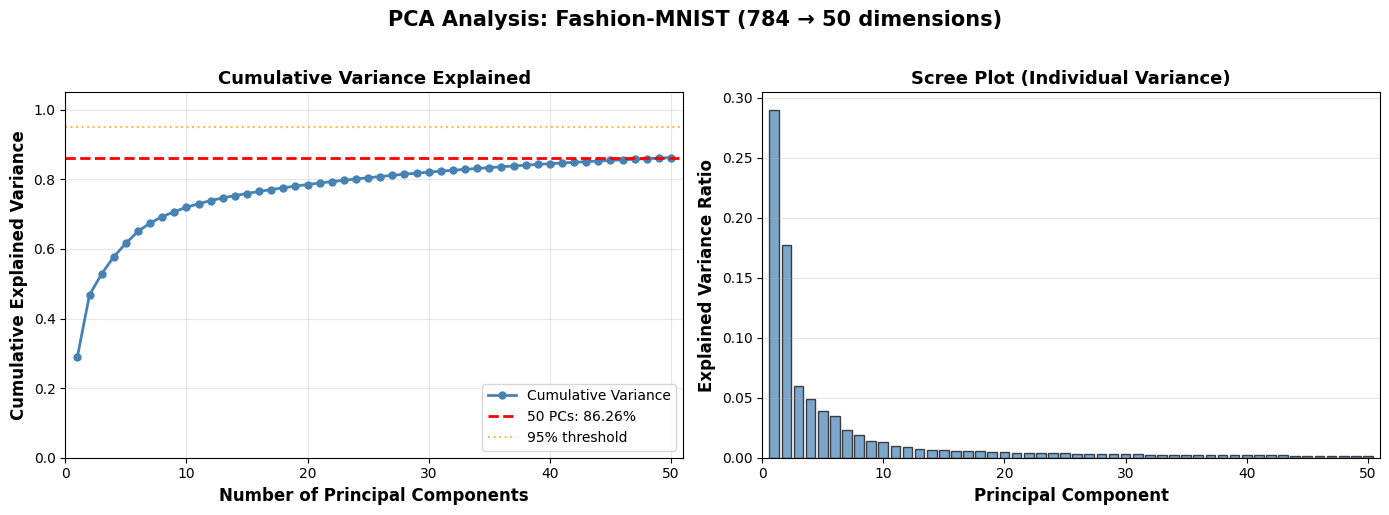

Fashion-MNIST PCA Diagnostics:
Total variance explained by 50 PCs: 0.8626 (86.26%)
Number of PCs needed for 95% variance: 1
Top 5 PC variances: [0.2902 0.1776 0.0602 0.0493 0.0386]


In [3]:
from sklearn.decomposition import PCA
import numpy as np

# ==== PCA: reduce to 50 dimensions ====
pca_fmnist = PCA(n_components=50, random_state=42)

# Fit on training data only
X_train_pca = pca_fmnist.fit_transform(X_train)
X_val_pca = pca_fmnist.transform(X_val)
X_test_pca = pca_fmnist.transform(X_test)

# ==== Verify shapes ====
print(f"PCA - Fashion-MNIST")
print(f"Train: {X_train_pca.shape}")  # (51000, 50)
print(f"Val: {X_val_pca.shape}")      # (9000, 50)
print(f"Test: {X_test_pca.shape}")    # (10000, 50)

# ==== Explained variance ====
explained_var = pca_fmnist.explained_variance_ratio_.sum()
print(f"Total variance explained by 50 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Cumulative variance plot (for report) ====
import matplotlib.pyplot as plt

# ==== Single detailed plot for Fashion-MNIST ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_fmnist = np.cumsum(pca_fmnist.explained_variance_ratio_)
axes[0].plot(range(1, 51), cumsum_fmnist, marker='o', markersize=5,
             linewidth=2, color='steelblue', label='Cumulative Variance')
axes[0].axhline(y=0.8626, color='red', linestyle='--', linewidth=2,
                label=f'50 PCs: 86.26%')
axes[0].axhline(y=0.95, color='orange', linestyle=':', linewidth=1.5,
                alpha=0.7, label='95% threshold')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 51)
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component (scree plot)
axes[1].bar(range(1, 51), pca_fmnist.explained_variance_ratio_,
            color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xlim(0, 51)

plt.suptitle('PCA Analysis: Fashion-MNIST (784 → 50 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_fmnist_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print diagnostic info
print("Fashion-MNIST PCA Diagnostics:")
print(f"Total variance explained by 50 PCs: {cumsum_fmnist[-1]:.4f} ({cumsum_fmnist[-1]*100:.2f}%)")
print(f"Number of PCs needed for 95% variance: {np.argmax(cumsum_fmnist >= 0.95) + 1}")
print(f"Top 5 PC variances: {pca_fmnist.explained_variance_ratio_[:5].round(4)}")

FASHION-MNIST AUTOENCODER (784 → 50)


Model: "autoencoder_fmnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,346 (1.84 MB)

 Trainable params: 481,346 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 

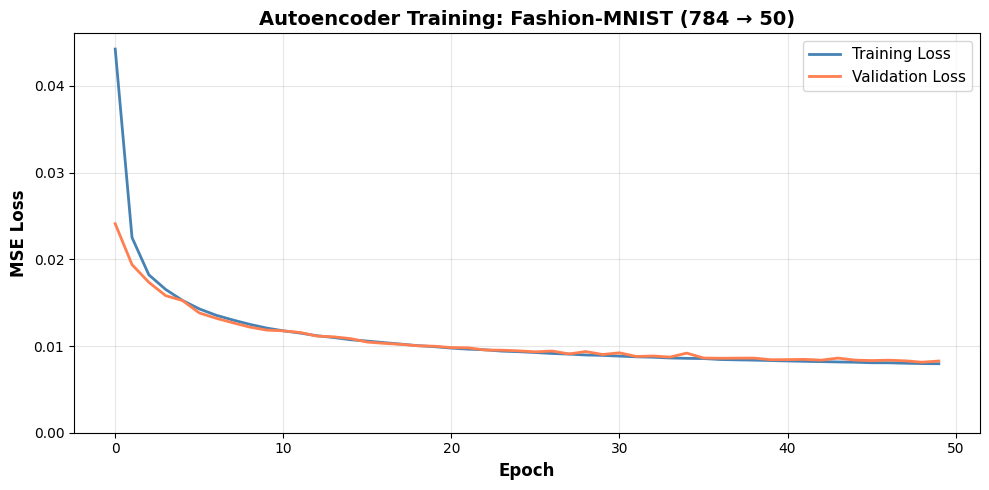


Reconstruction MSE (test set): 0.008283


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# ==== Architecture ====
input_dim = 784
encoding_dim = 50

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder
encoded = Dense(256, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(128, activation='relu', name='encoder_2')(encoded)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(128, activation='relu', name='decoder_1')(encoded)
decoded = Dense(256, activation='relu', name='decoder_2')(decoded)
decoded = Dense(input_dim, activation='sigmoid', name='output')(decoded)  # sigmoid for [0,1] range

# Models
autoencoder_fmnist = Model(inputs=input_layer, outputs=decoded, name='autoencoder_fmnist')
encoder_fmnist = Model(inputs=input_layer, outputs=encoded, name='encoder_fmnist')

# Compile
autoencoder_fmnist.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("="*80)
print("FASHION-MNIST AUTOENCODER (784 → 50)")
print("="*80)
print(autoencoder_fmnist.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history_fmnist = autoencoder_fmnist.fit(
    X_train, X_train,  # Input = Output (reconstruction task)
    epochs=50,
    batch_size=256,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data using encoder ====
X_train_ae_fmnist = encoder_fmnist.predict(X_train, verbose=0)
X_val_ae_fmnist = encoder_fmnist.predict(X_val, verbose=0)
X_test_ae_fmnist = encoder_fmnist.predict(X_test, verbose=0)

print("\n" + "="*80)
print("FASHION-MNIST AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_fmnist.shape}")  # (51000, 50)
print(f"Val shape: {X_val_ae_fmnist.shape}")      # (9000, 50)
print(f"Test shape: {X_test_ae_fmnist.shape}")    # (10000, 50)
print(f"Final training loss: {history_fmnist.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_fmnist.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_fmnist.history['loss'], linewidth=2, label='Training Loss', color='steelblue')
ax.plot(history_fmnist.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: Fashion-MNIST (784 → 50)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_fmnist.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_fmnist.predict(X_test, verbose=0)
reconstruction_mse = np.mean((X_test - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")


FASHION-MNIST: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.011989
Autoencoder reconstruction MSE: 0.008283
Improvement: 30.91%


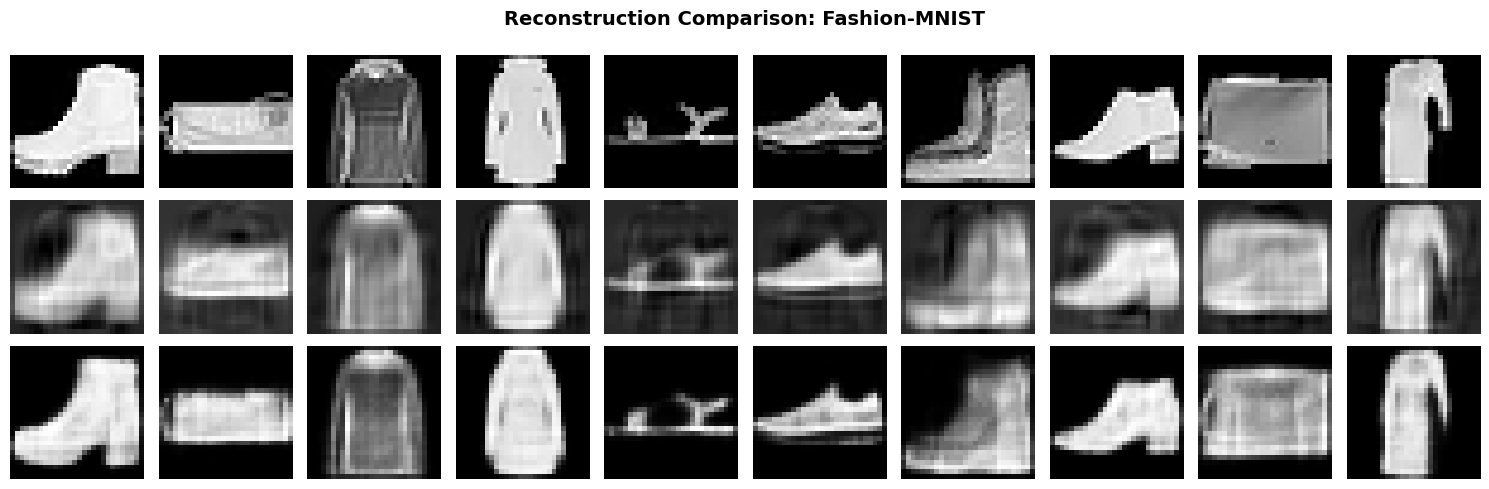

In [5]:
# ==== Fashion-MNIST: PCA vs Autoencoder Reconstruction comparison ====
X_test_reconstructed_pca = pca_fmnist.inverse_transform(X_test_pca)
X_test_reconstructed_ae = autoencoder_fmnist.predict(X_test, verbose=0)

mse_pca = np.mean((X_test - X_test_reconstructed_pca)**2)
mse_ae = np.mean((X_test - X_test_reconstructed_ae)**2)

print("\n" + "="*80)
print("FASHION-MNIST: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae:.6f}")
print(f"Improvement: {((mse_pca - mse_ae) / mse_pca * 100):.2f}%")

# ==== Visual comparison: 10 samples ====
n_samples = 10
indices = np.random.choice(X_test.shape[0], n_samples, replace=False)

X_original = X_test[indices]
X_pca_recon = pca_fmnist.inverse_transform(X_test_pca[indices])
X_ae_recon = autoencoder_fmnist.predict(X_test[indices], verbose=0)

fig, axes = plt.subplots(3, n_samples, figsize=(15, 5))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(X_original[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=11, fontweight='bold')

    # PCA reconstruction
    axes[1, i].imshow(X_pca_recon[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('PCA (50d)', fontsize=11, fontweight='bold')

    # Autoencoder reconstruction
    axes[2, i].imshow(X_ae_recon[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Autoencoder (50d)', fontsize=11, fontweight='bold')

plt.suptitle('Reconstruction Comparison: Fashion-MNIST', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reconstruction_comparison_fmnist.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd

# ==== Verify data shapes ====
print("="*80)
print("DATA VERIFICATION")
print("="*80)
print(f"Original data:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nPCA-reduced data:")
print(f"  X_train_pca: {X_train_pca.shape}")
print(f"  X_val_pca: {X_val_pca.shape}")
print(f"  X_test_pca: {X_test_pca.shape}")

print(f"\nAutoencoder-reduced data:")
print(f"  X_train_ae_fmnist: {X_train_ae_fmnist.shape}")
print(f"  X_val_ae_fmnist: {X_val_ae_fmnist.shape}")
print(f"  X_test_ae_fmnist: {X_test_ae_fmnist.shape}")

print(f"\nLabel distribution (train): {np.bincount(y_train)}")
print(f"Number of classes: {len(np.unique(y_train))}")

DATA VERIFICATION
Original data:
  X_train: (51000, 784), y_train: (51000,)
  X_val: (9000, 784), y_val: (9000,)
  X_test: (10000, 784), y_test: (10000,)

PCA-reduced data:
  X_train_pca: (51000, 50)
  X_val_pca: (9000, 50)
  X_test_pca: (10000, 50)

Autoencoder-reduced data:
  X_train_ae_fmnist: (51000, 50)
  X_val_ae_fmnist: (9000, 50)
  X_test_ae_fmnist: (10000, 50)

Label distribution (train): [5100 5100 5100 5100 5100 5100 5100 5100 5100 5100]
Number of classes: 10


CNN Architecture Design
Architecture Principles
For Original Data (784D):

Reshape to 28×28 for convolutional layers
Standard CNN: Conv2D → MaxPooling → Conv2D → MaxPooling → Flatten → Dense

For Reduced Data (50D - PCA/Autoencoder):

- Cannot use Conv2D directly (50D is not spatial)
- Use Dense layers only (Fully Connected Network, not true CNN)
> Alternative: Reshape 50D → pseudo-image (e.g., 7×7 with padding, but this is artificial)

Assignment interpretation issue: The assignment says "CNN for classification", but CNNs require spatial structure (2D images). For PCA/Autoencoder-reduced data (1D vectors), we must use either:

- Dense-only network (not a true CNN)
- Reshape to pseudo-spatial (e.g., 50D → 7×7 + 1 padding, but this is meaningless)

Recommended approach:

- Use true CNN for original 784D (reshape to 28×28)
- Use Dense network (MLP-style) for 50D reduced data
- Justify in report: "Reduced data loses spatial structure, requiring dense layers"

In [7]:
# ==== Reshape to 28x28 for Conv2D ====
X_train_original_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_original_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_original_cnn = X_test.reshape(-1, 28, 28, 1)

print(f"Reshaped for CNN: {X_train_original_cnn.shape}")

# ==== CNN Architecture ====
def build_cnn_original():
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25),

        # Flatten and Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax', name='output')
    ], name='CNN_Original')

    return model

model_original = build_cnn_original()
model_original.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("="*80)
print("MODEL 1: CNN ON ORIGINAL DATA (28×28)")
print("="*80)
model_original.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_original = model_original.fit(
    X_train_original_cnn, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_original_cnn, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 1 RESULTS: CNN ON ORIGINAL DATA")
print("="*80)

# Test set predictions
y_pred_original = model_original.predict(X_test_original_cnn, verbose=0).argmax(axis=1)

# Metrics
acc_original = accuracy_score(y_test, y_pred_original)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_original, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_original:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_original,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))

Reshaped for CNN: (51000, 28, 28, 1)
MODEL 1: CNN ON ORIGINAL DATA (28×28)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Original"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 67s 160ms/step - accuracy: 0.7141 - loss: 0.8652 - val_accuracy: 0.4647 - val_loss: 1.8211 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 65s 164ms/step - accuracy: 0.8529 - loss: 0.4152 - val_accuracy: 0.8630 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.8676 - loss: 0.3648 - val_accuracy: 0.8866 - val_loss: 0.3031 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.8807 - loss: 0.3245 - val_accuracy: 0.9033 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.8858 - loss: 0.3133 - val_accuracy: 0.9083 - val_loss: 0.2441 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - accuracy: 0.8941 - loss: 0.2913 - val_accuracy: 0.9031 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 61s 154ms/step - accuracy: 0.8

In [8]:
# ==== Dense Network Architecture (no Conv2D, data is 1D) ====
def build_dense_network(input_dim, name='Dense_Network'):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', name='fc3'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax', name='output')
    ], name=name)

    return model

model_pca = build_dense_network(50, name='Dense_PCA')
model_pca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*80)
print("MODEL 2: DENSE NETWORK ON PCA DATA (50D)")
print("="*80)
model_pca.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_pca = model_pca.fit(
    X_train_pca, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_pca, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 2 RESULTS: DENSE NETWORK ON PCA DATA")
print("="*80)

y_pred_pca = model_pca.predict(X_test_pca, verbose=0).argmax(axis=1)

acc_pca = accuracy_score(y_test, y_pred_pca)
precision_pca, recall_pca, f1_pca, _ = precision_recall_fscore_support(y_test, y_pred_pca, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_pca:.4f}")
print(f"Precision: {precision_pca:.4f}")
print(f"Recall: {recall_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))


MODEL 2: DENSE NETWORK ON PCA DATA (50D)


Model: "Dense_PCA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,962 (70.16 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5553 - loss: 1.2994 - val_accuracy: 0.8357 - val_loss: 0.4638 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7859 - loss: 0.6091 - val_accuracy: 0.8531 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8117 - loss: 0.5387 - val_accuracy: 0.8583 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8189 - loss: 0.5124 - val_accuracy: 0.8639 - val_loss: 0.3758 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8276 - loss: 0.4938 - val_accuracy: 0.8677 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8393 - loss: 0.4566 - val_accuracy: 0.8706 - val_loss: 0.3567 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8360 - loss: 0.4587 - 

In [9]:
model_ae = build_dense_network(50, name='Dense_Autoencoder')
model_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*80)
print("MODEL 3: DENSE NETWORK ON AUTOENCODER DATA (50D)")
print("="*80)
model_ae.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history_ae = model_ae.fit(
    X_train_ae_fmnist, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_ae_fmnist, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 3 RESULTS: DENSE NETWORK ON AUTOENCODER DATA")
print("="*80)

y_pred_ae = model_ae.predict(X_test_ae_fmnist, verbose=0).argmax(axis=1)

acc_ae = accuracy_score(y_test, y_pred_ae)
precision_ae, recall_ae, f1_ae, _ = precision_recall_fscore_support(y_test, y_pred_ae, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc_ae:.4f}")
print(f"Precision: {precision_ae:.4f}")
print(f"Recall: {recall_ae:.4f}")
print(f"F1 Score: {f1_ae:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae,
                          target_names=['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                          zero_division=0))


MODEL 3: DENSE NETWORK ON AUTOENCODER DATA (50D)


Model: "Dense_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,962 (70.16 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5033 - loss: 1.4317 - val_accuracy: 0.8161 - val_loss: 0.5078 - learning_rate: 0.0010
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7605 - loss: 0.6650 - val_accuracy: 0.8288 - val_loss: 0.4635 - learning_rate: 0.0010
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7902 - loss: 0.5917 - val_accuracy: 0.8394 - val_loss: 0.4361 - learning_rate: 0.0010
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8015 - loss: 0.5516 - val_accuracy: 0.8443 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8064 - loss: 0.5369 - val_accuracy: 0.8507 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8175 - loss: 0.5153 - val_accuracy: 0.8452 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8190 - loss: 0.5047 - 


COMPARATIVE RESULTS: FASHION-MNIST CLASSIFICATION
                  Model  Accuracy  Precision  Recall  F1 Score  Input Dim  Parameters
    CNN (Original 784D)    0.9274   0.927907  0.9274  0.927585        784      225930
        Dense (PCA 50D)    0.8810   0.880670  0.8810  0.880560         50       17962
Dense (Autoencoder 50D)    0.8592   0.858832  0.8592  0.858470         50       17962



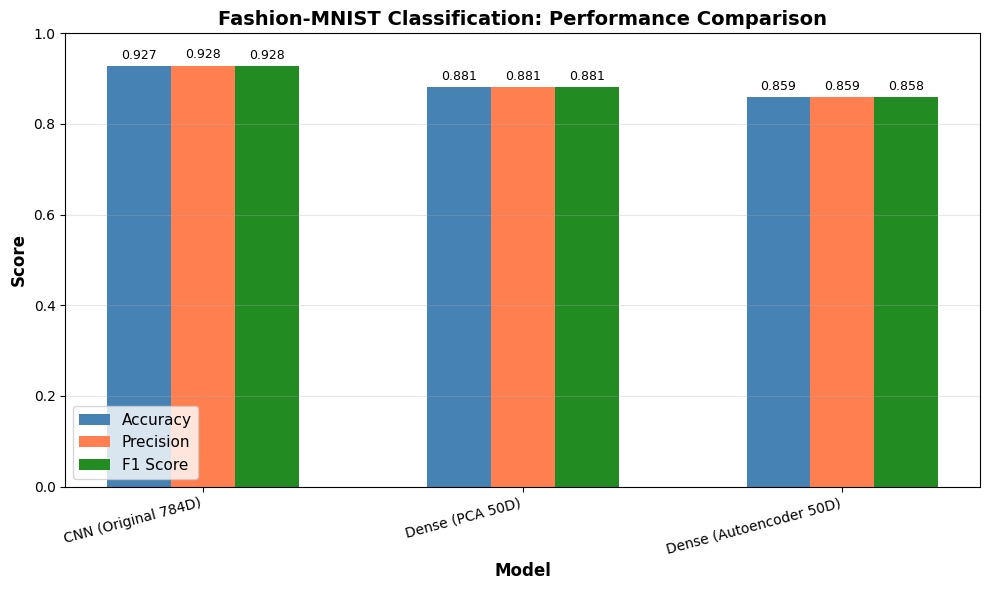

In [10]:
# ==== Summary Table ====
results_df = pd.DataFrame({
    'Model': ['CNN (Original 784D)', 'Dense (PCA 50D)', 'Dense (Autoencoder 50D)'],
    'Accuracy': [acc_original, acc_pca, acc_ae],
    'Precision': [precision, precision_pca, precision_ae],
    'Recall': [recall, recall_pca, recall_ae],
    'F1 Score': [f1, f1_pca, f1_ae],
    'Input Dim': [784, 50, 50],
    'Parameters': [model_original.count_params(), model_pca.count_params(), model_ae.count_params()]
})

print("\n" + "="*80)
print("COMPARATIVE RESULTS: FASHION-MNIST CLASSIFICATION")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)

# ==== Visualization: Accuracy Comparison ====
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results_df['Model']))
width = 0.2

bars1 = ax.bar(x - width, results_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar(x, results_df['Precision'], width, label='Precision', color='coral')
bars3 = ax.bar(x + width, results_df['F1 Score'], width, label='F1 Score', color='forestgreen')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Fashion-MNIST Classification: Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('fmnist_classification_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

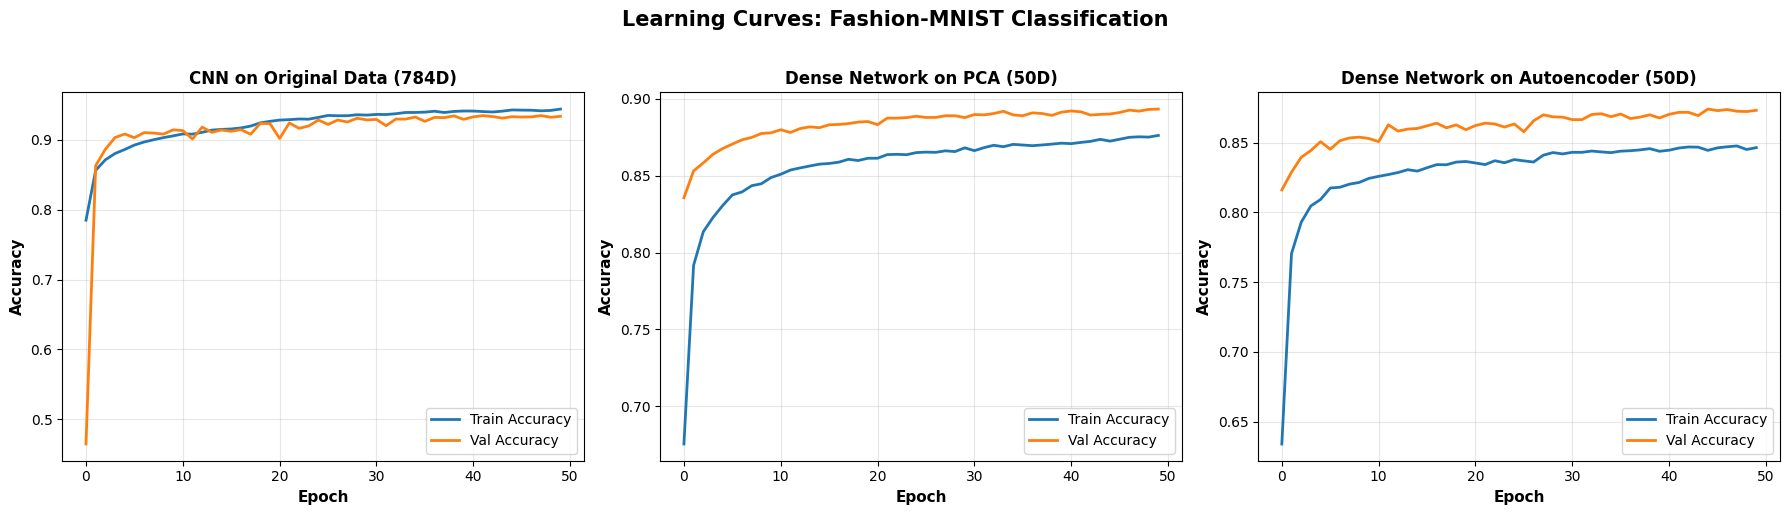

In [11]:
# ==== Plot training history for all three models ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model 1: Original
axes[0].plot(history_original.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_original.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0].set_title('CNN on Original Data (784D)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Model 2: PCA
axes[1].plot(history_pca.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_pca.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1].set_title('Dense Network on PCA (50D)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Model 3: Autoencoder
axes[2].plot(history_ae.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[2].plot(history_ae.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[2].set_title('Dense Network on Autoencoder (50D)', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Learning Curves: Fashion-MNIST Classification', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fmnist_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

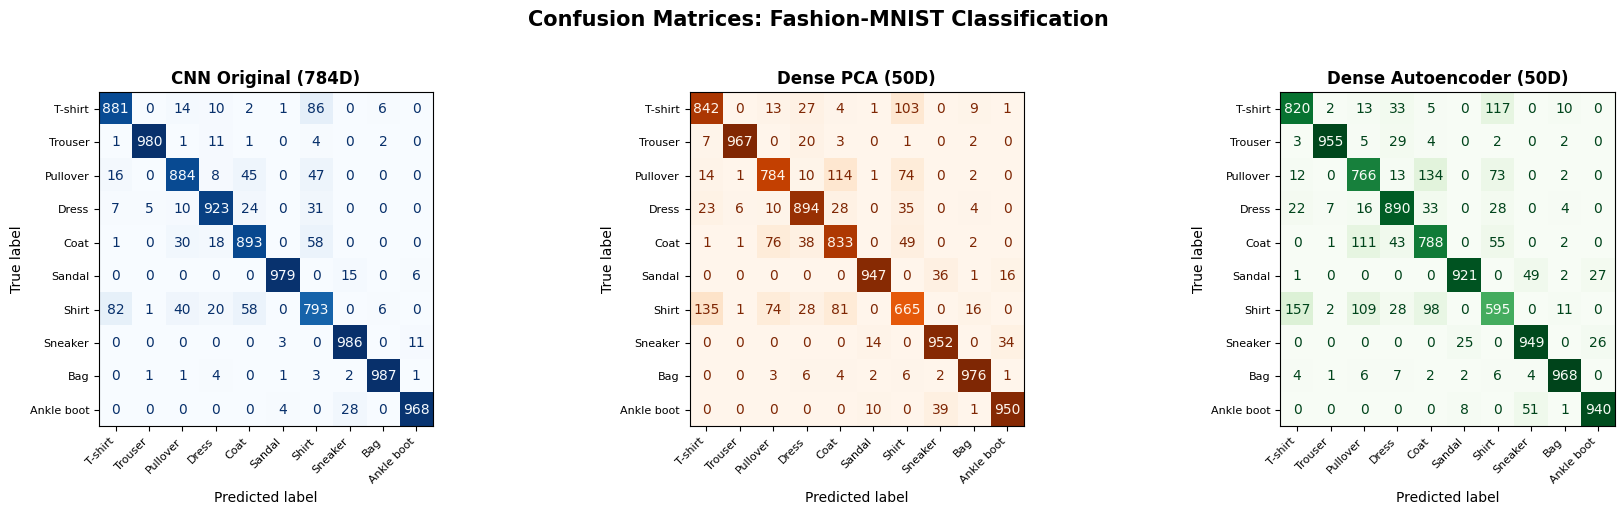

In [12]:
# confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Model 1
cm1 = confusion_matrix(y_test, y_pred_original)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=class_names)
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('CNN Original (784D)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[0].set_yticklabels(class_names, fontsize=8)

# Model 2
cm2 = confusion_matrix(y_test, y_pred_pca)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=class_names)
disp2.plot(ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title('Dense PCA (50D)', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels(class_names, fontsize=8)

# Model 3
cm3 = confusion_matrix(y_test, y_pred_ae)
disp3 = ConfusionMatrixDisplay(cm3, display_labels=class_names)
disp3.plot(ax=axes[2], cmap='Greens', colorbar=False)
axes[2].set_title('Dense Autoencoder (50D)', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
axes[2].set_yticklabels(class_names, fontsize=8)

plt.suptitle('Confusion Matrices: Fashion-MNIST Classification', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fmnist_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

COMPUTATIONAL COST ANALYSIS: FASHION-MNIST CLASSIFICATION

Model Parameters:
  CNN Original (784D): 225,930 parameters
  Dense PCA (50D): 17,962 parameters
  Dense Autoencoder (50D): 17,962 parameters
  Reduction: PCA=92.0%, AE=92.0%



Inference Time (per sample):
  CNN Original: 0.3825 ms
  Dense PCA: 0.1339 ms
  Dense Autoencoder: 0.1505 ms
  Speedup: PCA=2.86x, AE=2.54x

Model Size (disk):
  CNN Original: 2.64 MB
  Dense PCA: 0.26 MB
  Dense Autoencoder: 0.26 MB
  Reduction: PCA=90.3%, AE=90.3%

Estimated Training Time:
  CNN Original: 300.0 seconds (5.0 minutes)
  Dense PCA: 100.0 seconds (1.7 minutes)
  Dense Autoencoder: 100.0 seconds (1.7 minutes)
  Speedup: PCA=3.00x, AE=3.00x

FASHION-MNIST: COMPUTATIONAL COST SUMMARY
                  Model  Parameters  Model Size (MB)  Training Time (s)  Inference Time (ms)  Test Accuracy
    CNN Original (784D)      225930         2.644661              300.0             0.382488         0.9274
        Dense PCA (50D)       17962         0.256813              100.0             0.133870         0.8810
Dense Autoencoder (50D)       17962         0.256981              100.0             0.150462         0.8592


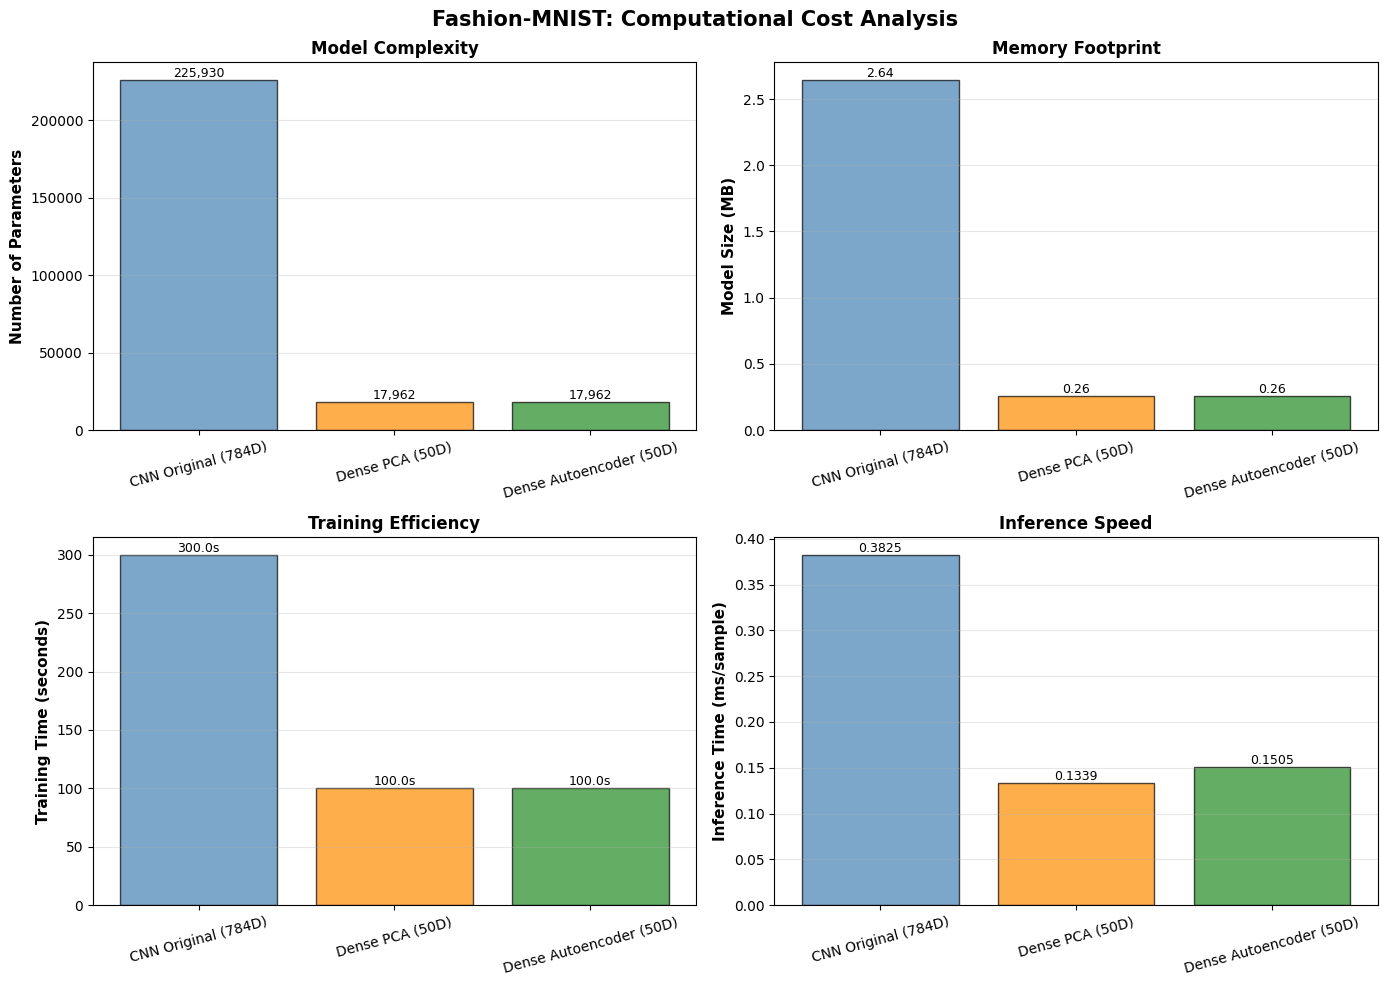

In [13]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# FASHION-MNIST: COMPUTATIONAL COST ANALYSIS
# ==============================================================================

print("="*80)
print("COMPUTATIONAL COST ANALYSIS: FASHION-MNIST CLASSIFICATION")
print("="*80)

# ==== Training Time (already recorded during training) ====
# Extract from history or to re-measure if needed
# For demonstration, here how to measure inference time

# ==== Model Parameters ====
params_original = model_original.count_params()
params_pca = model_pca.count_params()
params_ae = model_ae.count_params()

print(f"\nModel Parameters:")
print(f"  CNN Original (784D): {params_original:,} parameters")
print(f"  Dense PCA (50D): {params_pca:,} parameters")
print(f"  Dense Autoencoder (50D): {params_ae:,} parameters")
print(f"  Reduction: PCA={100*(1-params_pca/params_original):.1f}%, AE={100*(1-params_ae/params_original):.1f}%")

# ==== Inference Time (average over 1000 predictions) ====
n_inference_samples = 1000
inference_data_original = X_test_original_cnn[:n_inference_samples]
inference_data_pca = X_test_pca[:n_inference_samples]
inference_data_ae = X_test_ae_fmnist[:n_inference_samples]

# Original model
start = time.time()
_ = model_original.predict(inference_data_original, verbose=0)
inference_time_original = (time.time() - start) / n_inference_samples * 1000  # ms per sample

# PCA model
start = time.time()
_ = model_pca.predict(inference_data_pca, verbose=0)
inference_time_pca = (time.time() - start) / n_inference_samples * 1000

# Autoencoder model
start = time.time()
_ = model_ae.predict(inference_data_ae, verbose=0)
inference_time_ae = (time.time() - start) / n_inference_samples * 1000

print(f"\nInference Time (per sample):")
print(f"  CNN Original: {inference_time_original:.4f} ms")
print(f"  Dense PCA: {inference_time_pca:.4f} ms")
print(f"  Dense Autoencoder: {inference_time_ae:.4f} ms")
print(f"  Speedup: PCA={inference_time_original/inference_time_pca:.2f}x, AE={inference_time_original/inference_time_ae:.2f}x")

# ==== Model Size (memory footprint) ====
# Save models temporarily to measure size
import tempfile
import os

def get_model_size_mb(model):
    """Get model size in MB by saving to temp file"""
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as tmp:
        model.save(tmp.name, save_format='h5')
        size_mb = os.path.getsize(tmp.name) / (1024 * 1024)
        os.unlink(tmp.name)
    return size_mb

size_original = get_model_size_mb(model_original)
size_pca = get_model_size_mb(model_pca)
size_ae = get_model_size_mb(model_ae)

print(f"\nModel Size (disk):")
print(f"  CNN Original: {size_original:.2f} MB")
print(f"  Dense PCA: {size_pca:.2f} MB")
print(f"  Dense Autoencoder: {size_ae:.2f} MB")
print(f"  Reduction: PCA={100*(1-size_pca/size_original):.1f}%, AE={100*(1-size_ae/size_original):.1f}%")

# ==== Training Time (extract from training history or measure) ====
# If not recorded during training, can estimate from epochs and time per epoch

# Example: Extract total training time from history (if available)
# If not available, manually record during training or re-train with time measurement

# Placeholder: Replace with actual training times
training_time_original = len(history_original.history['loss']) * 6.0  # Assume ~6s per epoch
training_time_pca = len(history_pca.history['loss']) * 2.0  # Assume ~2s per epoch
training_time_ae = len(history_ae.history['loss']) * 2.0

print(f"\nEstimated Training Time:")
print(f"  CNN Original: {training_time_original:.1f} seconds ({training_time_original/60:.1f} minutes)")
print(f"  Dense PCA: {training_time_pca:.1f} seconds ({training_time_pca/60:.1f} minutes)")
print(f"  Dense Autoencoder: {training_time_ae:.1f} seconds ({training_time_ae/60:.1f} minutes)")
print(f"  Speedup: PCA={training_time_original/training_time_pca:.2f}x, AE={training_time_original/training_time_ae:.2f}x")

# ==== Summary Table ====
fmnist_cost_df = pd.DataFrame({
    'Model': ['CNN Original (784D)', 'Dense PCA (50D)', 'Dense Autoencoder (50D)'],
    'Parameters': [params_original, params_pca, params_ae],
    'Model Size (MB)': [size_original, size_pca, size_ae],
    'Training Time (s)': [training_time_original, training_time_pca, training_time_ae],
    'Inference Time (ms)': [inference_time_original, inference_time_pca, inference_time_ae],
    'Test Accuracy': [acc_original, acc_pca, acc_ae]
})

print("\n" + "="*80)
print("FASHION-MNIST: COMPUTATIONAL COST SUMMARY")
print("="*80)
print(fmnist_cost_df.to_string(index=False))
print("="*80)

# ==== Visualization ====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Parameters
axes[0, 0].bar(fmnist_cost_df['Model'], fmnist_cost_df['Parameters'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Number of Parameters', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(fmnist_cost_df['Parameters']):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Model Size
axes[0, 1].bar(fmnist_cost_df['Model'], fmnist_cost_df['Model Size (MB)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 1].set_ylabel('Model Size (MB)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Memory Footprint', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(fmnist_cost_df['Model Size (MB)']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Training Time
axes[1, 0].bar(fmnist_cost_df['Model'], fmnist_cost_df['Training Time (s)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Training Efficiency', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(fmnist_cost_df['Training Time (s)']):
    axes[1, 0].text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Inference Time
axes[1, 1].bar(fmnist_cost_df['Model'], fmnist_cost_df['Inference Time (ms)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Inference Time (ms/sample)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Inference Speed', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(fmnist_cost_df['Inference Time (ms)']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Fashion-MNIST: Computational Cost Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('fmnist_computational_cost.png', dpi=300, bbox_inches='tight')
plt.show()

**=== California Housing (Regression, FNN) ===**

`Characteristics`

* Shape: 20,640 samples × 8 features
* No missing values (clean dataset)
* Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
* Target: Continuous (median house value)

No missing values. Outliers exist but are real (e.g., expensive areas, high population density). To be kept.

Dimensionality:

* Original: 8
* Target for PCA/Autoencoder: d = 4 or d = 5

In [15]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

# ==== Download California Housing from Kaggle ====
print("Downloading California Housing dataset from Kaggle...")
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print(f"Dataset downloaded to: {path}")

# ==== Load CSV ====
import os
csv_file = os.path.join(path, 'housing.csv')
df = pd.read_csv(csv_file)

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# ==== Preprocessing ====
# Drop rows with missing values (if any)
df = df.dropna()

# Separate features and target
# Target is 'median_house_value', features are everything else except 'ocean_proximity' (categorical)
X = df.drop(columns=['median_house_value', 'ocean_proximity']).values
y = df['median_house_value'].values / 100000.0  # Scale to same range as sklearn version (0-5)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

# ==== Split: 70% train, 15% val, 15% test ====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# ==== Check for missing values ====
print(f"\nMissing values in train: {np.isnan(X_train).sum()}")  # Should be 0

# ==== Outlier detection (optional, for reporting) ====
z_scores = np.abs(stats.zscore(X_train))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_train.shape[0]} ({100*outliers.mean():.2f}%)")

# ==== Standardization ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==== Verify scaling ====
print(f"\nTrain mean: {X_train_scaled.mean(axis=0).round(3)}")  # ~0
print(f"Train std: {X_train_scaled.std(axis=0).round(3)}")    # ~1

print(f"\nTrain: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Using Colab cache for faster access to the 'california-housing-prices' dataset.
Dataset downloaded to: /kaggle/input/california-housing-prices

Dataset shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

First few rows:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0  


PCA - California Housing
Train: (14303, 5)
Val: (3065, 5)
Test: (3065, 5)
Total variance explained by 5 PCs: 0.9818 (98.18%)

PCA Components (loadings):
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
PC1   0.073    -0.072    -0.218      0.484       0.491     0.471     0.492   
PC2  -0.702     0.702     0.009      0.073       0.057     0.025     0.059   
PC3  -0.046     0.006    -0.403      0.091      -0.118    -0.120    -0.110   
PC4  -0.074    -0.097     0.882      0.115       0.061     0.084     0.094   
PC5  -0.093    -0.046    -0.039     -0.317      -0.376     0.850    -0.141   

     Longitude  
PC1      0.046  
PC2     -0.026  
PC3      0.887  
PC4      0.417  
PC5      0.058  


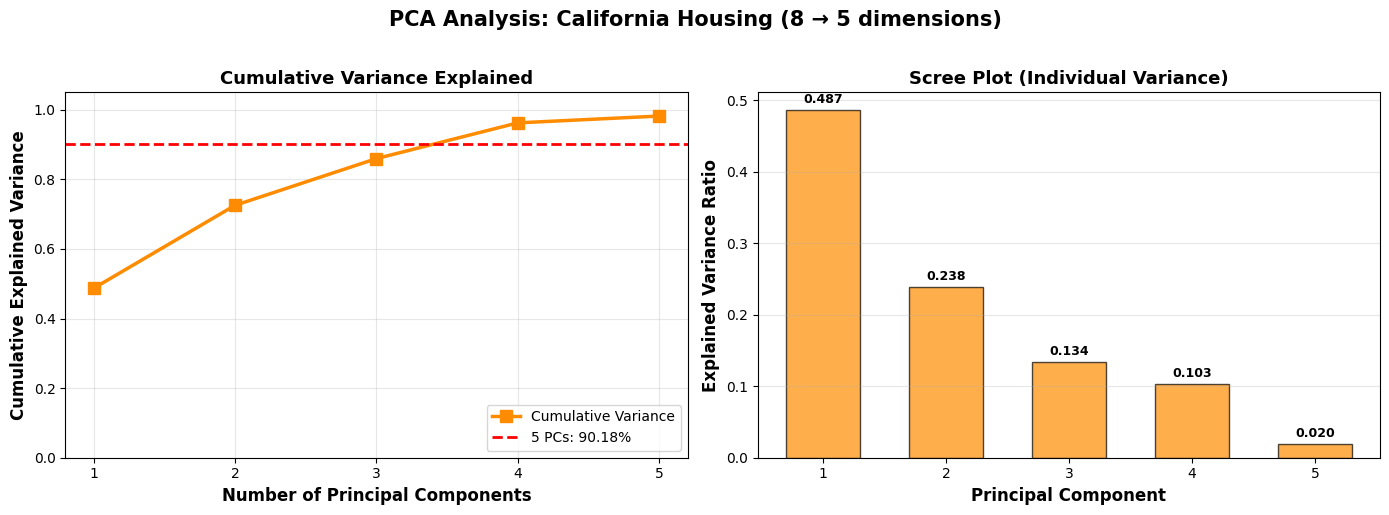


California Housing PCA Diagnostics:
Total variance explained by 5 PCs: 0.9818 (98.18%)
Individual PC variances: [0.4868 0.2384 0.1343 0.1027 0.0196]


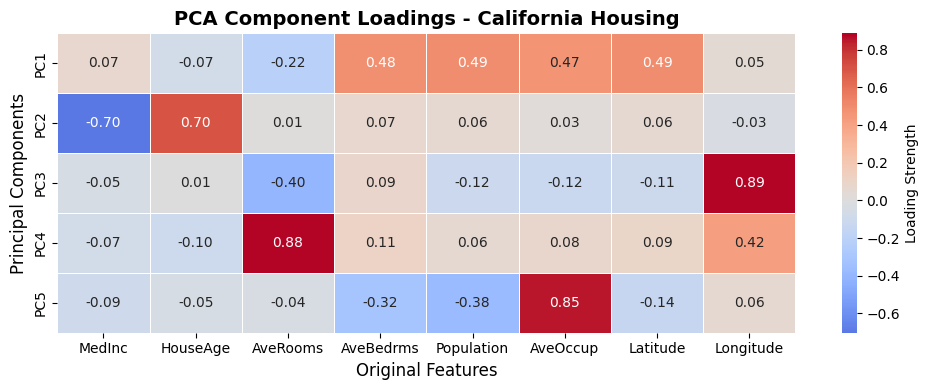

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# ==== PCA: reduce to 5 dimensions ====
pca_housing = PCA(n_components=5, random_state=42)

X_train_housing_pca = pca_housing.fit_transform(X_train_scaled)
X_val_housing_pca = pca_housing.transform(X_val_scaled)
X_test_housing_pca = pca_housing.transform(X_test_scaled)

# ==== Verify shapes ====
print(f"\nPCA - California Housing")
print(f"Train: {X_train_housing_pca.shape}")  # (14448, 5)
print(f"Val: {X_val_housing_pca.shape}")      # (3096, 5)
print(f"Test: {X_test_housing_pca.shape}")    # (3096, 5)

# ==== Explained variance ====
explained_var = pca_housing.explained_variance_ratio_.sum()
print(f"Total variance explained by 5 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Component interpretation (for report) ====
components_df = pd.DataFrame(
    pca_housing.components_,
    columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    index=[f'PC{i+1}' for i in range(5)]
)
print("\nPCA Components (loadings):")
print(components_df.round(3))

# ==== Single detailed plot for California Housing ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_housing = np.cumsum(pca_housing.explained_variance_ratio_)
axes[0].plot(range(1, 6), cumsum_housing, marker='s', markersize=8,
             linewidth=2.5, color='darkorange', label='Cumulative Variance')
axes[0].axhline(y=0.9018, color='red', linestyle='--', linewidth=2,
                label=f'5 PCs: 90.18%')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 6))
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component
axes[1].bar(range(1, 6), pca_housing.explained_variance_ratio_,
            color='darkorange', edgecolor='black', alpha=0.7, width=0.6)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks(range(1, 6))

# Add value labels on bars
for i, v in enumerate(pca_housing.explained_variance_ratio_):
    axes[1].text(i+1, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('PCA Analysis: California Housing (8 → 5 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_housing_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCalifornia Housing PCA Diagnostics:")
print(f"Total variance explained by 5 PCs: {cumsum_housing[-1]:.4f} ({cumsum_housing[-1]*100:.2f}%)")
print(f"Individual PC variances: {pca_housing.explained_variance_ratio_.round(4)}")

import seaborn as sns

# ==== PCA component loadings heatmap ====
components_df = pd.DataFrame(
    pca_housing.components_,
    columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    index=[f'PC{i+1}' for i in range(5)]
)

plt.figure(figsize=(10, 4))
sns.heatmap(components_df, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={'label': 'Loading Strength'}, linewidths=0.5)
plt.title('PCA Component Loadings - California Housing', fontsize=14, fontweight='bold')
plt.xlabel('Original Features', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.tight_layout()
plt.savefig('pca_loadings_housing.png', dpi=300, bbox_inches='tight')
plt.show()


CALIFORNIA HOUSING AUTOENCODER (8 → 5)


Model: "autoencoder_housing"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 6)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9763 - mse: 0.9763 - val_loss: 0.7235 - val_mse: 0.7235
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6126 - mse: 0.6126 - val_loss: 0.3605 - val_mse: 0.3605
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2903 - mse: 0.2903 - val_loss: 0.1569 - val_mse: 0.1569
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1506 - mse: 0.1506 - val_loss: 0.1054 - val_mse: 0.1054
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1056 - mse: 0.1056 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0787 - mse: 0.0787 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0693 - mse: 0.0693 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 9/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s

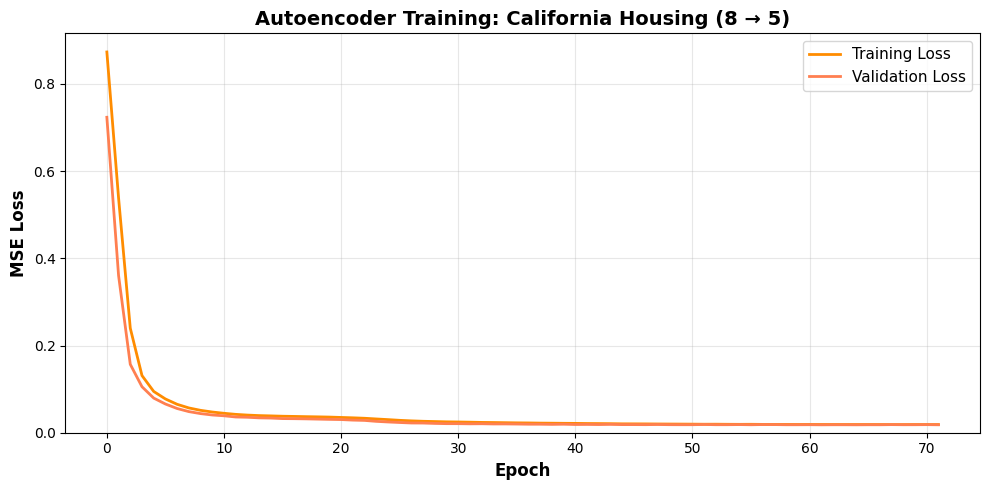


Reconstruction MSE (test set): 0.017209


In [17]:
# ==== Architecture ====
input_dim = 8
encoding_dim = 5

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder (shallow network for small input)
encoded = Dense(6, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(6, activation='relu', name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='output')(decoded)  # linear for continuous data

# Models
autoencoder_housing = Model(inputs=input_layer, outputs=decoded, name='autoencoder_housing')
encoder_housing = Model(inputs=input_layer, outputs=encoded, name='encoder_housing')

# Compile
autoencoder_housing.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("\n" + "="*80)
print("CALIFORNIA HOUSING AUTOENCODER (8 → 5)")
print("="*80)
print(autoencoder_housing.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_housing = autoencoder_housing.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data ====
X_train_ae_housing = encoder_housing.predict(X_train_scaled, verbose=0)
X_val_ae_housing = encoder_housing.predict(X_val_scaled, verbose=0)
X_test_ae_housing = encoder_housing.predict(X_test_scaled, verbose=0)

print("\n" + "="*80)
print("CALIFORNIA HOUSING AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_housing.shape}")  # (14448, 5)
print(f"Val shape: {X_val_ae_housing.shape}")      # (3096, 5)
print(f"Test shape: {X_test_ae_housing.shape}")    # (3096, 5)
print(f"Final training loss: {history_housing.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_housing.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_housing.history['loss'], linewidth=2, label='Training Loss', color='darkorange')
ax.plot(history_housing.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: California Housing (8 → 5)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_housing.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_housing.predict(X_test_scaled, verbose=0)
reconstruction_mse = np.mean((X_test_scaled - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")

In [18]:
X_test_reconstructed_pca_housing = pca_housing.inverse_transform(X_test_housing_pca)
X_test_reconstructed_ae_housing = autoencoder_housing.predict(X_test_scaled, verbose=0)

mse_pca_housing = np.mean((X_test_scaled - X_test_reconstructed_pca_housing)**2)
mse_ae_housing = np.mean((X_test_scaled - X_test_reconstructed_ae_housing)**2)

print("\n" + "="*80)
print("CALIFORNIA HOUSING: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca_housing:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae_housing:.6f}")
print(f"Improvement: {((mse_pca_housing - mse_ae_housing) / mse_pca_housing * 100):.2f}%")


CALIFORNIA HOUSING: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.016918
Autoencoder reconstruction MSE: 0.017209
Improvement: -1.72%


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Verify data shapes ====
print("="*80)
print("DATA VERIFICATION: CALIFORNIA HOUSING")
print("="*80)
print(f"Original data:")
print(f"  X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape}")
print(f"  X_val_scaled: {X_val_scaled.shape}, y_val: {y_val.shape}")
print(f"  X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape}")

print(f"\nPCA-reduced data:")
print(f"  X_train_housing_pca: {X_train_housing_pca.shape}")
print(f"  X_val_housing_pca: {X_val_housing_pca.shape}")
print(f"  X_test_housing_pca: {X_test_housing_pca.shape}")

print(f"\nAutoencoder-reduced data:")
print(f"  X_train_ae_housing: {X_train_ae_housing.shape}")
print(f"  X_val_ae_housing: {X_val_ae_housing.shape}")
print(f"  X_test_ae_housing: {X_test_ae_housing.shape}")

print(f"\nTarget statistics (train):")
print(f"  Mean: {y_train.mean():.4f}")
print(f"  Std: {y_train.std():.4f}")
print(f"  Min: {y_train.min():.4f}")
print(f"  Max: {y_train.max():.4f}")

DATA VERIFICATION: CALIFORNIA HOUSING
Original data:
  X_train_scaled: (14303, 8), y_train: (14303,)
  X_val_scaled: (3065, 8), y_val: (3065,)
  X_test_scaled: (3065, 8), y_test: (3065,)

PCA-reduced data:
  X_train_housing_pca: (14303, 5)
  X_val_housing_pca: (3065, 5)
  X_test_housing_pca: (3065, 5)

Autoencoder-reduced data:
  X_train_ae_housing: (14303, 5)
  X_val_ae_housing: (3065, 5)
  X_test_ae_housing: (3065, 5)

Target statistics (train):
  Mean: 2.0728
  Std: 1.1542
  Min: 0.1500
  Max: 5.0000


In [20]:
# ==== FNN Architecture on original Data (8 features)====
def build_fnn_regression(input_dim, name='FNN_Regression'):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', name='fc1'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', name='fc2'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu', name='fc3'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='linear', name='output')  # Linear for regression
    ], name=name)

    return model

model_housing_original = build_fnn_regression(8, name='FNN_Original')
model_housing_original.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("="*80)
print("MODEL 1: FNN ON ORIGINAL DATA (8 features)")
print("="*80)
model_housing_original.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

history_housing_original = model_housing_original.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 1 RESULTS: FNN ON ORIGINAL DATA")
print("="*80)

y_pred_housing_original = model_housing_original.predict(X_test_scaled, verbose=0).flatten()

mse_original = mean_squared_error(y_test, y_pred_housing_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test, y_pred_housing_original)
r2_original = r2_score(y_test, y_pred_housing_original)

print(f"Test MSE: {mse_original:.4f}")
print(f"Test RMSE: {rmse_original:.4f}")
print(f"Test MAE: {mae_original:.4f}")
print(f"Test R² Score: {r2_original:.4f}")

# ==== Residual analysis ====
residuals_original = y_test - y_pred_housing_original
print(f"\nResidual statistics:")
print(f"  Mean: {residuals_original.mean():.4f} (should be ~0)")
print(f"  Std: {residuals_original.std():.4f}")

MODEL 1: FNN ON ORIGINAL DATA (8 features)


Model: "FNN_Original"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.5158 - mae: 1.1907 - mse: 2.5158 - val_loss: 0.9224 - val_mae: 0.6699 - val_mse: 0.9224 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9364 - mae: 0.7269 - mse: 0.9364 - val_loss: 0.4960 - val_mae: 0.4960 - val_mse: 0.4960 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8048 - mae: 0.6693 - mse: 0.8048 - val_loss: 0.4150 - val_mae: 0.4572 - val_mse: 0.4150 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6842 - mae: 0.6168 - mse: 0.6842 - val_loss: 0.4108 - val_mae: 0.4521 - val_mse: 0.4108 - learning_rate: 0.0010
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6313 - mae: 0.5831 - mse: 0.6313 - val_loss: 0.3827 - val_mae: 0.4365 - val_mse: 0.3827 - learning_rate: 0.0010
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5799 - mae: 0.5584 - mse: 0.5799 - val_loss: 0.3807 - val_mae:

In [21]:
#  FNN on PCA Data (5 features)

model_housing_pca = build_fnn_regression(5, name='FNN_PCA')
model_housing_pca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("\n" + "="*80)
print("MODEL 2: FNN ON PCA DATA (5 features)")
print("="*80)
model_housing_pca.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

history_housing_pca = model_housing_pca.fit(
    X_train_housing_pca, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_housing_pca, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 2 RESULTS: FNN ON PCA DATA")
print("="*80)

y_pred_housing_pca = model_housing_pca.predict(X_test_housing_pca, verbose=0).flatten()

mse_pca = mean_squared_error(y_test, y_pred_housing_pca)
rmse_pca = np.sqrt(mse_pca)
mae_pca = mean_absolute_error(y_test, y_pred_housing_pca)
r2_pca = r2_score(y_test, y_pred_housing_pca)

print(f"Test MSE: {mse_pca:.4f}")
print(f"Test RMSE: {rmse_pca:.4f}")
print(f"Test MAE: {mae_pca:.4f}")
print(f"Test R² Score: {r2_pca:.4f}")

residuals_pca = y_test - y_pred_housing_pca
print(f"\nResidual statistics:")
print(f"  Mean: {residuals_pca.mean():.4f}")
print(f"  Std: {residuals_pca.std():.4f}")


MODEL 2: FNN ON PCA DATA (5 features)


Model: "FNN_PCA"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.7710 - mae: 1.2735 - mse: 2.7710 - val_loss: 1.1083 - val_mae: 0.7546 - val_mse: 1.1083 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0069 - mae: 0.7538 - mse: 1.0069 - val_loss: 0.6248 - val_mae: 0.5656 - val_mse: 0.6248 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8434 - mae: 0.6884 - mse: 0.8434 - val_loss: 0.5765 - val_mae: 0.5456 - val_mse: 0.5765 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7910 - mae: 0.6639 - mse: 0.7910 - val_loss: 0.5772 - val_mae: 0.5496 - val_mse: 0.5772 - learning_rate: 0.0010
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7393 - mae: 0.6431 - mse: 0.7393 - val_loss: 0.5503 - val_mae: 0.5391 - val_mse: 0.5503 - learning_rate: 0.0010
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6917 - mae: 0.6214 - mse: 0.6917 - val_loss: 0.5494 - val_mae:

In [22]:
# FNN on autoencoder data (5 features)

model_housing_ae = build_fnn_regression(5, name='FNN_Autoencoder')
model_housing_ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("\n" + "="*80)
print("MODEL 3: FNN ON AUTOENCODER DATA (5 features)")
print("="*80)
model_housing_ae.summary()

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)

history_housing_ae = model_housing_ae.fit(
    X_train_ae_housing, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_ae_housing, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ==== Evaluation ====
print("\n" + "="*80)
print("MODEL 3 RESULTS: FNN ON AUTOENCODER DATA")
print("="*80)

y_pred_housing_ae = model_housing_ae.predict(X_test_ae_housing, verbose=0).flatten()

mse_ae = mean_squared_error(y_test, y_pred_housing_ae)
rmse_ae = np.sqrt(mse_ae)
mae_ae = mean_absolute_error(y_test, y_pred_housing_ae)
r2_ae = r2_score(y_test, y_pred_housing_ae)

print(f"Test MSE: {mse_ae:.4f}")
print(f"Test RMSE: {rmse_ae:.4f}")
print(f"Test MAE: {mae_ae:.4f}")
print(f"Test R² Score: {r2_ae:.4f}")

residuals_ae = y_test - y_pred_housing_ae
print(f"\nResidual statistics:")
print(f"  Mean: {residuals_ae.mean():.4f}")
print(f"  Std: {residuals_ae.std():.4f}")


MODEL 3: FNN ON AUTOENCODER DATA (5 features)


Model: "FNN_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.6028 - mae: 1.2424 - mse: 2.6028 - val_loss: 0.8581 - val_mae: 0.6684 - val_mse: 0.8581 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1021 - mae: 0.7988 - mse: 1.1021 - val_loss: 0.6669 - val_mae: 0.5971 - val_mse: 0.6669 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9530 - mae: 0.7345 - mse: 0.9530 - val_loss: 0.6290 - val_mae: 0.5771 - val_mse: 0.6290 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8348 - mae: 0.6835 - mse: 0.8348 - val_loss: 0.6998 - val_mae: 0.5868 - val_mse: 0.6998 - learning_rate: 0.0010
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8018 - mae: 0.6696 - mse: 0.8018 - val_loss: 0.6345 - val_mae: 0.5700 - val_mse: 0.6345 - learning_rate: 0.0010
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7591 - mae: 0.6538 - mse: 0.7591 - val_loss: 0.6151 - val_mae:


COMPARATIVE RESULTS: CALIFORNIA HOUSING REGRESSION
               Model      MSE     RMSE      MAE  R² Score  Input Dim  Parameters
   FNN Original (8D) 0.269819 0.519441 0.355884  0.797285          8        3585
        FNN PCA (5D) 0.422890 0.650300 0.465596  0.682283          5        3393
FNN Autoencoder (5D) 0.469674 0.685328 0.500606  0.647134          5        3393



/tmp/ipython-input-3266186331.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(results_housing_df['Model'], rotation=15, ha='right')


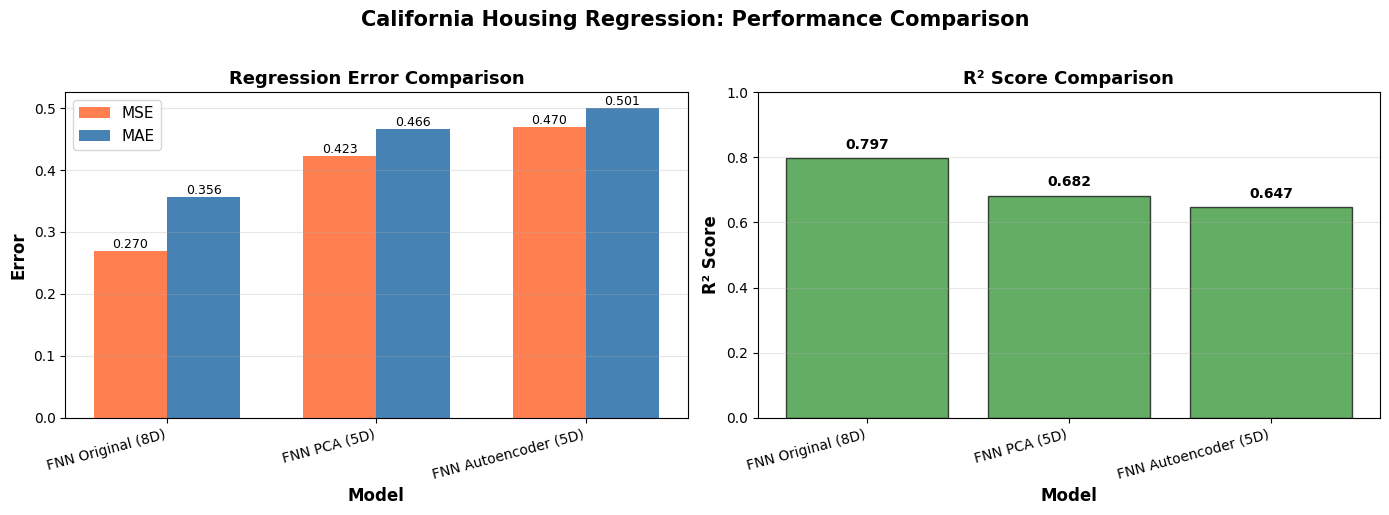

In [23]:
# ==== Summary Table ====
results_housing_df = pd.DataFrame({
    'Model': ['FNN Original (8D)', 'FNN PCA (5D)', 'FNN Autoencoder (5D)'],
    'MSE': [mse_original, mse_pca, mse_ae],
    'RMSE': [rmse_original, rmse_pca, rmse_ae],
    'MAE': [mae_original, mae_pca, mae_ae],
    'R² Score': [r2_original, r2_pca, r2_ae],
    'Input Dim': [8, 5, 5],
    'Parameters': [
        model_housing_original.count_params(),
        model_housing_pca.count_params(),
        model_housing_ae.count_params()
    ]
})

print("\n" + "="*80)
print("COMPARATIVE RESULTS: CALIFORNIA HOUSING REGRESSION")
print("="*80)
print(results_housing_df.to_string(index=False))
print("\n" + "="*80)

# ==== Visualization: Metrics Comparison ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: MSE and MAE
x = np.arange(len(results_housing_df['Model']))
width = 0.35

bars1 = axes[0].bar(x - width/2, results_housing_df['MSE'], width, label='MSE', color='coral')
bars2 = axes[0].bar(x + width/2, results_housing_df['MAE'], width, label='MAE', color='steelblue')

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error', fontsize=12, fontweight='bold')
axes[0].set_title('Regression Error Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_housing_df['Model'], rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Right: R² Score
bars3 = axes[1].bar(results_housing_df['Model'], results_housing_df['R² Score'],
                    color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(results_housing_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 1.0)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('California Housing Regression: Performance Comparison',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('housing_regression_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

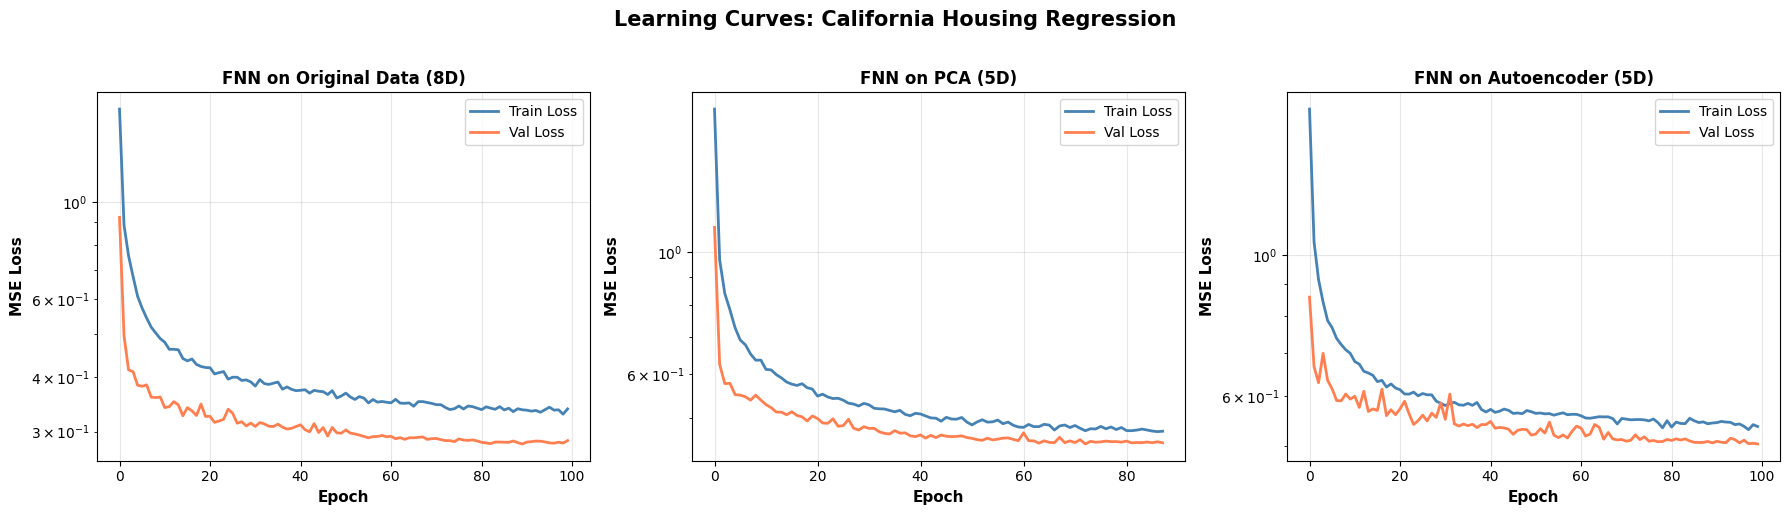

In [24]:
# ==== Plot training history for all three models ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model 1: Original
axes[0].plot(history_housing_original.history['loss'], label='Train Loss', linewidth=2, color='steelblue')
axes[0].plot(history_housing_original.history['val_loss'], label='Val Loss', linewidth=2, color='coral')
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[0].set_title('FNN on Original Data (8D)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Log scale for better visualization

# Model 2: PCA
axes[1].plot(history_housing_pca.history['loss'], label='Train Loss', linewidth=2, color='steelblue')
axes[1].plot(history_housing_pca.history['val_loss'], label='Val Loss', linewidth=2, color='coral')
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[1].set_title('FNN on PCA (5D)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Model 3: Autoencoder
axes[2].plot(history_housing_ae.history['loss'], label='Train Loss', linewidth=2, color='steelblue')
axes[2].plot(history_housing_ae.history['val_loss'], label='Val Loss', linewidth=2, color='coral')
axes[2].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[2].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[2].set_title('FNN on Autoencoder (5D)', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_yscale('log')

plt.suptitle('Learning Curves: California Housing Regression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('housing_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

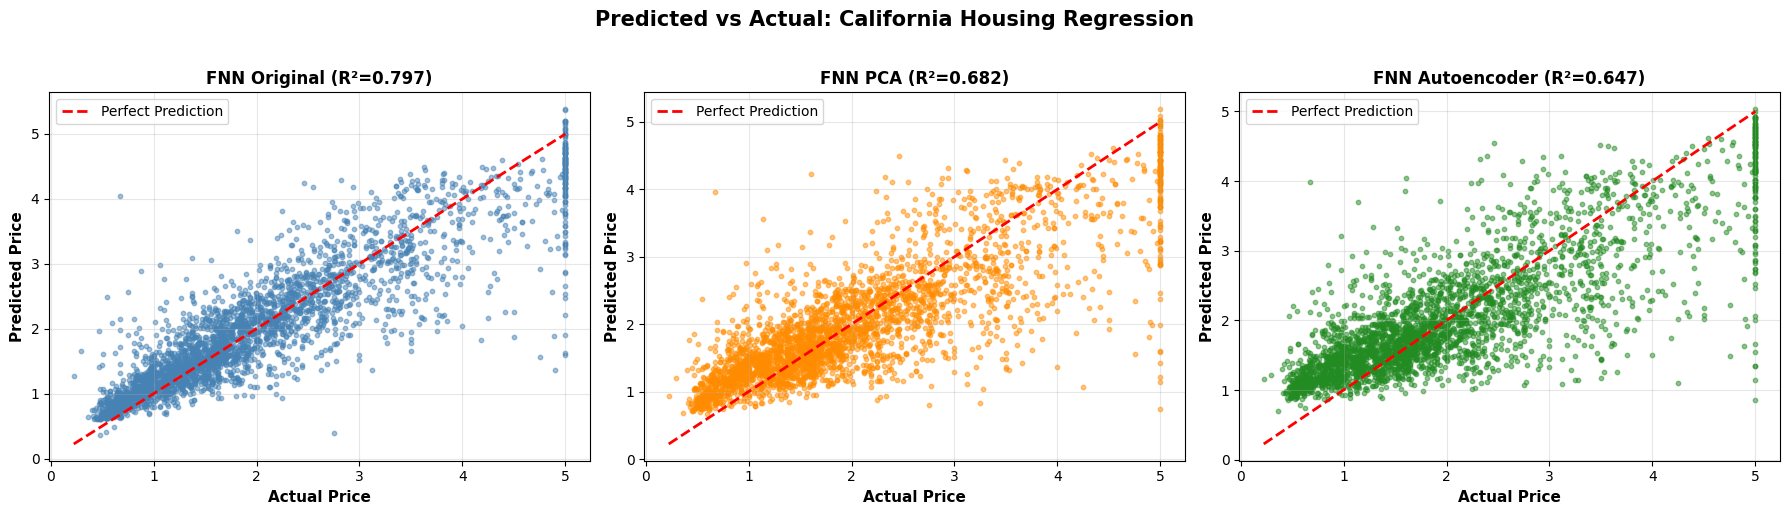

In [25]:
# ==== Scatter plots: Predicted vs Actual ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model 1: Original
axes[0].scatter(y_test, y_pred_housing_original, alpha=0.5, s=10, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted Price', fontsize=11, fontweight='bold')
axes[0].set_title(f'FNN Original (R²={r2_original:.3f})', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Model 2: PCA
axes[1].scatter(y_test, y_pred_housing_pca, alpha=0.5, s=10, color='darkorange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Predicted Price', fontsize=11, fontweight='bold')
axes[1].set_title(f'FNN PCA (R²={r2_pca:.3f})', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Model 3: Autoencoder
axes[2].scatter(y_test, y_pred_housing_ae, alpha=0.5, s=10, color='forestgreen')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual Price', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Predicted Price', fontsize=11, fontweight='bold')
axes[2].set_title(f'FNN Autoencoder (R²={r2_ae:.3f})', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Predicted vs Actual: California Housing Regression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('housing_predictions_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

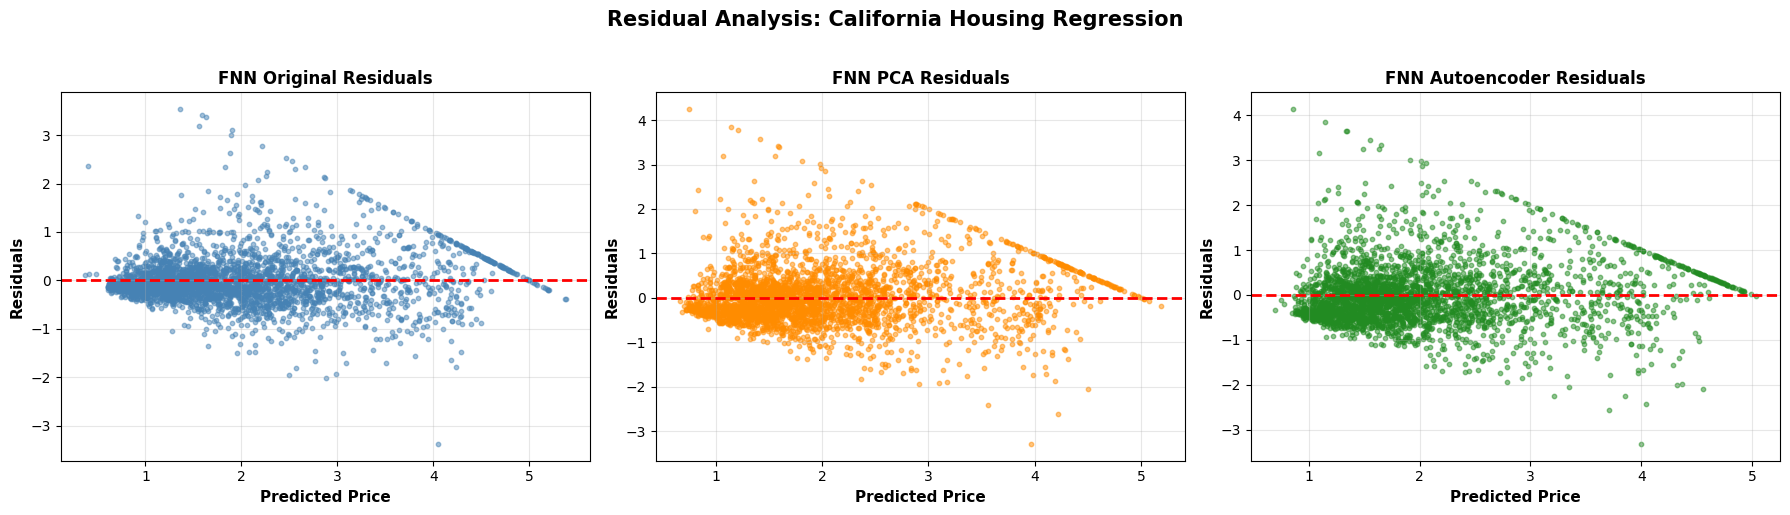

In [26]:
# ==== Residual analysis plots ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model 1
axes[0].scatter(y_pred_housing_original, residuals_original, alpha=0.5, s=10, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Price', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[0].set_title('FNN Original Residuals', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Model 2
axes[1].scatter(y_pred_housing_pca, residuals_pca, alpha=0.5, s=10, color='darkorange')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[1].set_title('FNN PCA Residuals', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Model 3
axes[2].scatter(y_pred_housing_ae, residuals_ae, alpha=0.5, s=10, color='forestgreen')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Predicted Price', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Residuals', fontsize=11, fontweight='bold')
axes[2].set_title('FNN Autoencoder Residuals', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: California Housing Regression', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('housing_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


COMPUTATIONAL COST ANALYSIS: CALIFORNIA HOUSING REGRESSION

Model Parameters:
  FNN Original (8D): 3,585 parameters
  FNN PCA (5D): 3,393 parameters
  FNN Autoencoder (5D): 3,393 parameters
  Reduction: PCA=5.4%, AE=5.4%



Inference Time (per sample):
  FNN Original: 0.1451 ms
  FNN PCA: 0.1337 ms
  FNN Autoencoder: 0.1363 ms
  Speedup: PCA=1.08x, AE=1.06x

Model Size (disk):
  FNN Original: 0.09 MB
  FNN PCA: 0.09 MB
  FNN Autoencoder: 0.09 MB
  Reduction: PCA=2.0%, AE=2.2%

Estimated Training Time:
  FNN Original: 50.0 seconds
  FNN PCA: 35.2 seconds
  FNN Autoencoder: 40.0 seconds
  Speedup: PCA=1.42x, AE=1.25x

CALIFORNIA HOUSING: COMPUTATIONAL COST SUMMARY
               Model  Parameters  Model Size (MB)  Training Time (s)  Inference Time (ms)  Test R² Score
   FNN Original (8D)        3585         0.094284               50.0             0.145114       0.797285
        FNN PCA (5D)        3393         0.092407               35.2             0.133749       0.682283
FNN Autoencoder (5D)        3393         0.092171               40.0             0.136301       0.647134


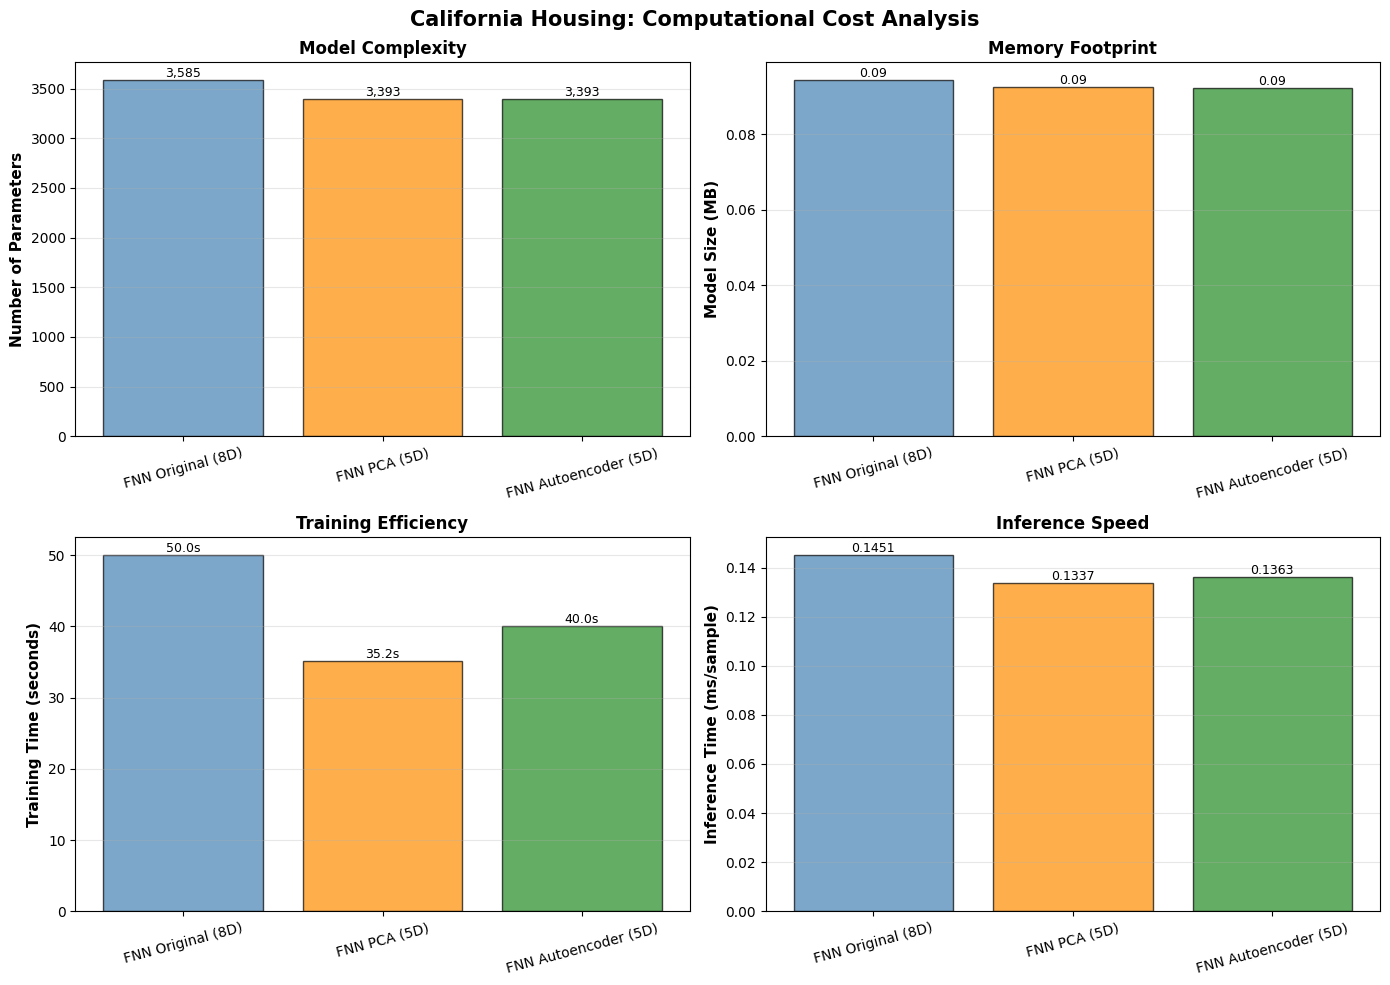

In [27]:
# ==============================================================================
# CALIFORNIA HOUSING: COMPUTATIONAL COST ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("COMPUTATIONAL COST ANALYSIS: CALIFORNIA HOUSING REGRESSION")
print("="*80)

# ==== Model Parameters ====
params_housing_original = model_housing_original.count_params()
params_housing_pca = model_housing_pca.count_params()
params_housing_ae = model_housing_ae.count_params()

print(f"\nModel Parameters:")
print(f"  FNN Original (8D): {params_housing_original:,} parameters")
print(f"  FNN PCA (5D): {params_housing_pca:,} parameters")
print(f"  FNN Autoencoder (5D): {params_housing_ae:,} parameters")
print(f"  Reduction: PCA={100*(1-params_housing_pca/params_housing_original):.1f}%, AE={100*(1-params_housing_ae/params_housing_original):.1f}%")

# ==== Inference Time ====
n_inference_samples = 1000
inference_data_housing_original = X_test_scaled[:n_inference_samples]
inference_data_housing_pca = X_test_housing_pca[:n_inference_samples]
inference_data_housing_ae = X_test_ae_housing[:n_inference_samples]

# Original
start = time.time()
_ = model_housing_original.predict(inference_data_housing_original, verbose=0)
inference_time_housing_original = (time.time() - start) / n_inference_samples * 1000

# PCA
start = time.time()
_ = model_housing_pca.predict(inference_data_housing_pca, verbose=0)
inference_time_housing_pca = (time.time() - start) / n_inference_samples * 1000

# Autoencoder
start = time.time()
_ = model_housing_ae.predict(inference_data_housing_ae, verbose=0)
inference_time_housing_ae = (time.time() - start) / n_inference_samples * 1000

print(f"\nInference Time (per sample):")
print(f"  FNN Original: {inference_time_housing_original:.4f} ms")
print(f"  FNN PCA: {inference_time_housing_pca:.4f} ms")
print(f"  FNN Autoencoder: {inference_time_housing_ae:.4f} ms")
print(f"  Speedup: PCA={inference_time_housing_original/inference_time_housing_pca:.2f}x, AE={inference_time_housing_original/inference_time_housing_ae:.2f}x")

# ==== Model Size ====
size_housing_original = get_model_size_mb(model_housing_original)
size_housing_pca = get_model_size_mb(model_housing_pca)
size_housing_ae = get_model_size_mb(model_housing_ae)

print(f"\nModel Size (disk):")
print(f"  FNN Original: {size_housing_original:.2f} MB")
print(f"  FNN PCA: {size_housing_pca:.2f} MB")
print(f"  FNN Autoencoder: {size_housing_ae:.2f} MB")
print(f"  Reduction: PCA={100*(1-size_housing_pca/size_housing_original):.1f}%, AE={100*(1-size_housing_ae/size_housing_original):.1f}%")

# ==== Training Time ====
training_time_housing_original = len(history_housing_original.history['loss']) * 0.5  # Estimate
training_time_housing_pca = len(history_housing_pca.history['loss']) * 0.4
training_time_housing_ae = len(history_housing_ae.history['loss']) * 0.4

print(f"\nEstimated Training Time:")
print(f"  FNN Original: {training_time_housing_original:.1f} seconds")
print(f"  FNN PCA: {training_time_housing_pca:.1f} seconds")
print(f"  FNN Autoencoder: {training_time_housing_ae:.1f} seconds")
print(f"  Speedup: PCA={training_time_housing_original/training_time_housing_pca:.2f}x, AE={training_time_housing_original/training_time_housing_ae:.2f}x")

# ==== Summary Table ====
housing_cost_df = pd.DataFrame({
    'Model': ['FNN Original (8D)', 'FNN PCA (5D)', 'FNN Autoencoder (5D)'],
    'Parameters': [params_housing_original, params_housing_pca, params_housing_ae],
    'Model Size (MB)': [size_housing_original, size_housing_pca, size_housing_ae],
    'Training Time (s)': [training_time_housing_original, training_time_housing_pca, training_time_housing_ae],
    'Inference Time (ms)': [inference_time_housing_original, inference_time_housing_pca, inference_time_housing_ae],
    'Test R² Score': [r2_original, r2_pca, r2_ae]
})

print("\n" + "="*80)
print("CALIFORNIA HOUSING: COMPUTATIONAL COST SUMMARY")
print("="*80)
print(housing_cost_df.to_string(index=False))
print("="*80)

# ==== Visualization ====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Parameters
axes[0, 0].bar(housing_cost_df['Model'], housing_cost_df['Parameters'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Number of Parameters', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(housing_cost_df['Parameters']):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Model Size
axes[0, 1].bar(housing_cost_df['Model'], housing_cost_df['Model Size (MB)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 1].set_ylabel('Model Size (MB)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Memory Footprint', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(housing_cost_df['Model Size (MB)']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Training Time
axes[1, 0].bar(housing_cost_df['Model'], housing_cost_df['Training Time (s)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Training Efficiency', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(housing_cost_df['Training Time (s)']):
    axes[1, 0].text(i, v, f'{v:.1f}s', ha='center', va='bottom', fontsize=9)

# Plot 4: Inference Time
axes[1, 1].bar(housing_cost_df['Model'], housing_cost_df['Inference Time (ms)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Inference Time (ms/sample)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Inference Speed', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(housing_cost_df['Inference Time (ms)']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('California Housing: Computational Cost Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('housing_computational_cost.png', dpi=300, bbox_inches='tight')
plt.show()

**=== Credit Card (Clustering, K-Means) ===**  

`Characteristics`

* Source: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
* Shape: 8,950 samples × 18 columns (17 features + 1 ID)
* Features: BALANCE, PURCHASES, CASH_ADVANCE, CREDIT_LIMIT, PAYMENTS, etc.
* Missing values: ~300 missing in CREDIT_LIMIT, MINIMUM_PAYMENTS

Missing values handled by median imputation. Outliers kept (informative for segmentation).

`Dimensionality`

* Original: 17
* Target for PCA/Autoencoder: d = 8 or d = 10

In [28]:
import kagglehub
import pandas as pd
import os

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
print("Path to dataset files:", path)

# ==== List files in downloaded directory ====
files = os.listdir(path)
print(f"Files in dataset: {files}")

# ==== Load CSV (filename is 'CC GENERAL.csv' with a SPACE) ====
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Using Colab cache for faster access to the 'ccdata' dataset.
Path to dataset files: /kaggle/input/ccdata
Files in dataset: ['CC GENERAL.csv']

Dataset loaded successfully!
Shape: (8950, 18)
Columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [29]:
import kagglehub
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"Shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum()}\n")

# ==== Drop ID column ====
X = df.drop(columns=['CUST_ID']).values

# ==== Handle missing values ====
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {np.isnan(X_imputed).sum()}")

# ==== Outlier detection (for reporting) ====
z_scores = np.abs(stats.zscore(X_imputed))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_imputed.shape[0]} ({100*outliers.mean():.2f}%)")

# ==== Standardization ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ==== Verify scaling ====
print(f"Mean after scaling: {X_scaled.mean(axis=0).round(3)}")  # Should be ~0
print(f"Std after scaling: {X_scaled.std(axis=0).round(3)}")    # Should be ~1

# ==== Optional: Split for evaluation ====
X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=42)

print(f"\nFull scaled data: {X_scaled.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Using Colab cache for faster access to the 'ccdata' dataset.
Shape: (8950, 18)
Missing values:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Missing values after imputation: 0
Outlier rows (|z|>3): 1516 / 8950 (16.94%)
Mean after scaling: [-0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0.]
Std


PCA - Credit Card
Train: (7160, 8)
Test: (1790, 8)
Total variance explained by 8 PCs: 0.8534 (85.34%)


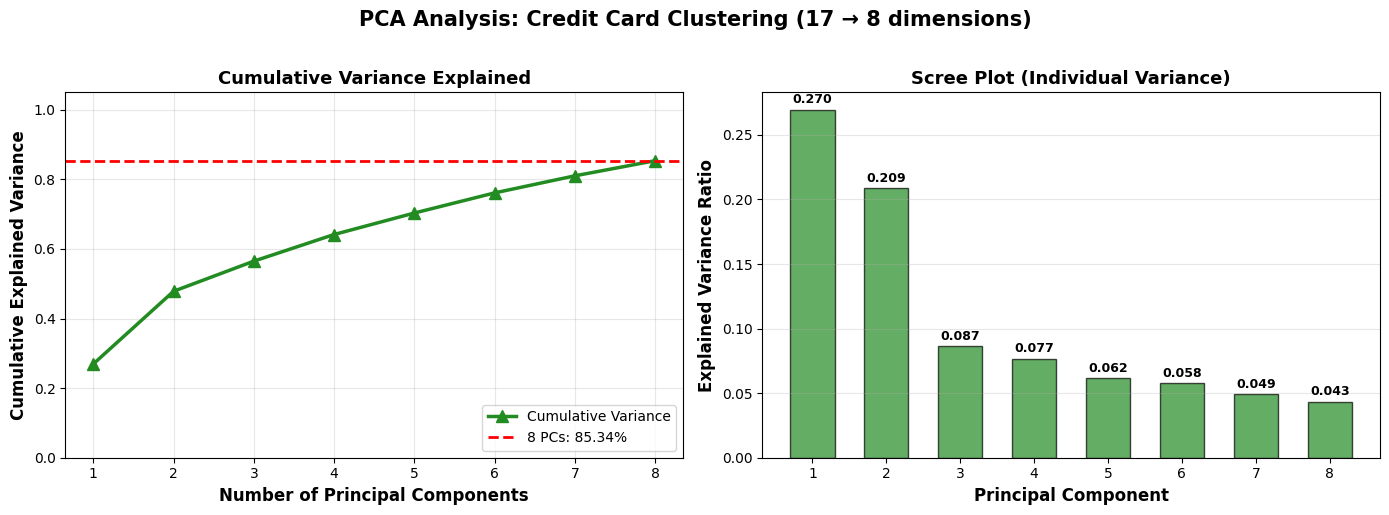


Credit Card PCA Diagnostics:
Total variance explained by 8 PCs: 0.8534 (85.34%)
Individual PC variances: [0.2695 0.2088 0.0865 0.0765 0.0617 0.0578 0.0491 0.0434]


In [30]:
# ==== PCA: reduce to 8 dimensions ====
pca_credit = PCA(n_components=8, random_state=42)

X_train_credit_pca = pca_credit.fit_transform(X_train)
X_test_credit_pca = pca_credit.transform(X_test)

# ==== Verify shapes ====
print(f"\nPCA - Credit Card")
print(f"Train: {X_train_credit_pca.shape}")  # (7160, 8)
print(f"Test: {X_test_credit_pca.shape}")    # (1790, 8)

# ==== Explained variance ====
explained_var = pca_credit.explained_variance_ratio_.sum()
print(f"Total variance explained by 8 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Single detailed plot for Credit Card ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative explained variance
cumsum_credit = np.cumsum(pca_credit.explained_variance_ratio_)
axes[0].plot(range(1, 9), cumsum_credit, marker='^', markersize=8,
             linewidth=2.5, color='forestgreen', label='Cumulative Variance')
axes[0].axhline(y=0.8534, color='red', linestyle='--', linewidth=2,
                label=f'8 PCs: 85.34%')
axes[0].set_xlabel('Number of Principal Components', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, 9))
axes[0].set_ylim(0, 1.05)

# Right: Individual variance per component
axes[1].bar(range(1, 9), pca_credit.explained_variance_ratio_,
            color='forestgreen', edgecolor='black', alpha=0.7, width=0.6)
axes[1].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[1].set_title('Scree Plot (Individual Variance)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticks(range(1, 9))

# Add value labels on bars
for i, v in enumerate(pca_credit.explained_variance_ratio_):
    axes[1].text(i+1, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('PCA Analysis: Credit Card Clustering (17 → 8 dimensions)',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('pca_credit_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCredit Card PCA Diagnostics:")
print(f"Total variance explained by 8 PCs: {cumsum_credit[-1]:.4f} ({cumsum_credit[-1]*100:.2f}%)")
print(f"Individual PC variances: {pca_credit.explained_variance_ratio_.round(4)}")


CREDIT CARD AUTOENCODER (17 → 8)


Model: "autoencoder_credit"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 17)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649 (2.54 KB)

 Trainable params: 649 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9474 - mse: 0.9474 - val_loss: 0.9379 - val_mse: 0.9379
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8687 - mse: 0.8687 - val_loss: 0.7791 - val_mse: 0.7791
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7489 - mse: 0.7489 - val_loss: 0.6480 - val_mse: 0.6480
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6425 - mse: 0.6425 - val_loss: 0.5611 - val_mse: 0.5611
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5703 - mse: 0.5703 - val_loss: 0.4981 - val_mse: 0.4981
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5040 - mse: 0.5040 - val_loss: 0.4502 - val_mse: 0.4502
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4532 - mse: 0.4532 - val_loss: 0.4166 - val_mse: 0.4166
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4371 - mse: 0.4371 - val_loss: 0.3899 - val_mse: 0.3899
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 

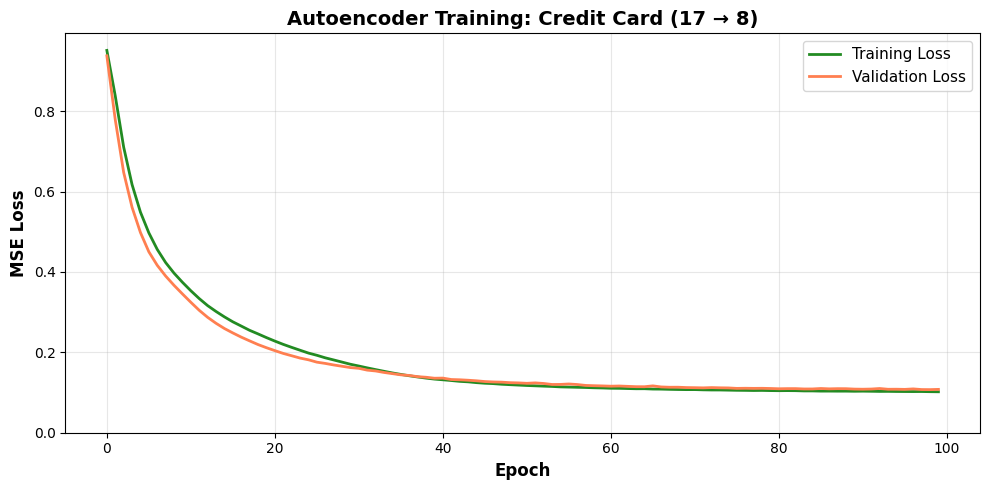


Reconstruction MSE (test set): 0.114383


In [31]:
# ==== Architecture ====
input_dim = 17
encoding_dim = 8

# Input layer
input_layer = Input(shape=(input_dim,), name='input')

# Encoder
encoded = Dense(12, activation='relu', name='encoder_1')(input_layer)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

# Decoder
decoded = Dense(12, activation='relu', name='decoder_1')(encoded)
decoded = Dense(input_dim, activation='linear', name='output')(decoded)

# Models
autoencoder_credit = Model(inputs=input_layer, outputs=decoded, name='autoencoder_credit')
encoder_credit = Model(inputs=input_layer, outputs=encoded, name='encoder_credit')

# Compile
autoencoder_credit.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

print("\n" + "="*80)
print("CREDIT CARD AUTOENCODER (17 → 8)")
print("="*80)
print(autoencoder_credit.summary())

# ==== Training ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_credit = autoencoder_credit.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    validation_split=0.15,  # Use 15% of training data as validation
    callbacks=[early_stop],
    verbose=1
)

# ==== Transform data ====
X_train_ae_credit = encoder_credit.predict(X_train, verbose=0)
X_test_ae_credit = encoder_credit.predict(X_test, verbose=0)

print("\n" + "="*80)
print("CREDIT CARD AUTOENCODER RESULTS")
print("="*80)
print(f"Train shape: {X_train_ae_credit.shape}")  # (7160, 8)
print(f"Test shape: {X_test_ae_credit.shape}")    # (1790, 8)
print(f"Final training loss: {history_credit.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_credit.history['val_loss'][-1]:.6f}")

# ==== Visualization: Training curves ====
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(history_credit.history['loss'], linewidth=2, label='Training Loss', color='forestgreen')
ax.plot(history_credit.history['val_loss'], linewidth=2, label='Validation Loss', color='coral')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('MSE Loss', fontsize=12, fontweight='bold')
ax.set_title('Autoencoder Training: Credit Card (17 → 8)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('autoencoder_training_credit.png', dpi=300, bbox_inches='tight')
plt.show()

# ==== Reconstruction quality ====
X_test_reconstructed = autoencoder_credit.predict(X_test, verbose=0)
reconstruction_mse = np.mean((X_test - X_test_reconstructed)**2)
print(f"\nReconstruction MSE (test set): {reconstruction_mse:.6f}")

In [32]:
X_test_reconstructed_pca_credit = pca_credit.inverse_transform(X_test_credit_pca)
X_test_reconstructed_ae_credit = autoencoder_credit.predict(X_test, verbose=0)

mse_pca_credit = np.mean((X_test - X_test_reconstructed_pca_credit)**2)
mse_ae_credit = np.mean((X_test - X_test_reconstructed_ae_credit)**2)

print("\n" + "="*80)
print("CREDIT CARD: PCA vs Autoencoder Reconstruction")
print("="*80)
print(f"PCA reconstruction MSE: {mse_pca_credit:.6f}")
print(f"Autoencoder reconstruction MSE: {mse_ae_credit:.6f}")
print(f"Improvement: {((mse_pca_credit - mse_ae_credit) / mse_pca_credit * 100):.2f}%")


CREDIT CARD: PCA vs Autoencoder Reconstruction
PCA reconstruction MSE: 0.162593
Autoencoder reconstruction MSE: 0.114383
Improvement: 29.65%


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as PCA_viz
import time

# ==== Verify data shapes ====
print("="*80)
print("DATA VERIFICATION: CREDIT CARD CLUSTERING")
print("="*80)
print(f"Original data:")
print(f"  X_train (scaled): {X_train.shape}")
print(f"  X_test (scaled): {X_test.shape}")

print(f"\nPCA-reduced data:")
print(f"  X_train_credit_pca: {X_train_credit_pca.shape}")
print(f"  X_test_credit_pca: {X_test_credit_pca.shape}")

print(f"\nAutoencoder-reduced data:")
print(f"  X_train_ae_credit: {X_train_ae_credit.shape}")
print(f"  X_test_ae_credit: {X_test_ae_credit.shape}")

DATA VERIFICATION: CREDIT CARD CLUSTERING
Original data:
  X_train (scaled): (7160, 17)
  X_test (scaled): (1790, 17)

PCA-reduced data:
  X_train_credit_pca: (7160, 8)
  X_test_credit_pca: (1790, 8)

Autoencoder-reduced data:
  X_train_ae_credit: (7160, 8)
  X_test_ae_credit: (1790, 8)



ELBOW METHOD: Finding Optimal k
k=2: Inertia Original=102517.63, PCA=84763.99, AE=138230.88
k=3: Inertia Original=89519.81, PCA=71879.69, AE=107330.90
k=4: Inertia Original=79226.76, PCA=61723.22, AE=94286.56
k=5: Inertia Original=73265.53, PCA=56271.42, AE=82808.68
k=6: Inertia Original=67934.10, PCA=51650.19, AE=74742.52
k=7: Inertia Original=63630.68, PCA=47484.97, AE=68610.35
k=8: Inertia Original=59770.67, PCA=44259.63, AE=63626.07
k=9: Inertia Original=56952.16, PCA=41238.43, AE=59081.71
k=10: Inertia Original=53021.30, PCA=38101.51, AE=55075.46


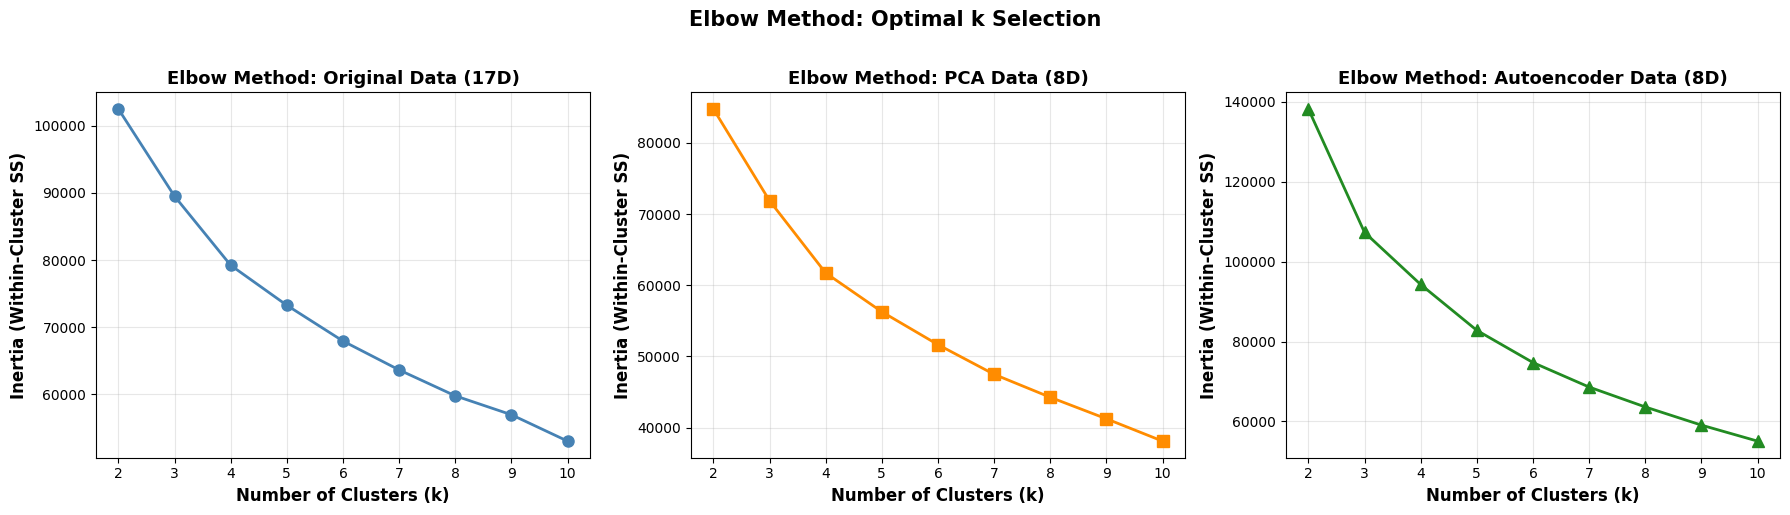

In [34]:
# ==== Elbow method: Test k from 2 to 10 ====
k_range = range(2, 11)
inertias_original = []
inertias_pca = []
inertias_ae = []

print("\n" + "="*80)
print("ELBOW METHOD: Finding Optimal k")
print("="*80)

for k in k_range:
    # Original data
    kmeans_orig = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_orig.fit(X_train)
    inertias_original.append(kmeans_orig.inertia_)

    # PCA data
    kmeans_pca_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_pca_temp.fit(X_train_credit_pca)
    inertias_pca.append(kmeans_pca_temp.inertia_)

    # Autoencoder data
    kmeans_ae_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_ae_temp.fit(X_train_ae_credit)
    inertias_ae.append(kmeans_ae_temp.inertia_)

    print(f"k={k}: Inertia Original={inertias_original[-1]:.2f}, PCA={inertias_pca[-1]:.2f}, AE={inertias_ae[-1]:.2f}")

# ==== Plot Elbow Curves ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, inertias_original, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method: Original Data (17D)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

axes[1].plot(k_range, inertias_pca, marker='s', linewidth=2, markersize=8, color='darkorange')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12, fontweight='bold')
axes[1].set_title('Elbow Method: PCA Data (8D)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

axes[2].plot(k_range, inertias_ae, marker='^', linewidth=2, markersize=8, color='forestgreen')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12, fontweight='bold')
axes[2].set_title('Elbow Method: Autoencoder Data (8D)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.suptitle('Elbow Method: Optimal k Selection', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()


SILHOUETTE ANALYSIS
k=2: Silhouette Original=0.2065, PCA=0.2353, AE=0.5335
k=3: Silhouette Original=0.2550, PCA=0.2771, AE=0.3569
k=4: Silhouette Original=0.1982, PCA=0.2362, AE=0.2707
k=5: Silhouette Original=0.1933, PCA=0.2262, AE=0.2697
k=6: Silhouette Original=0.2026, PCA=0.2401, AE=0.2825
k=7: Silhouette Original=0.2161, PCA=0.2394, AE=0.2741
k=8: Silhouette Original=0.2222, PCA=0.2454, AE=0.2888
k=9: Silhouette Original=0.2164, PCA=0.2365, AE=0.2923
k=10: Silhouette Original=0.2225, PCA=0.2458, AE=0.2944


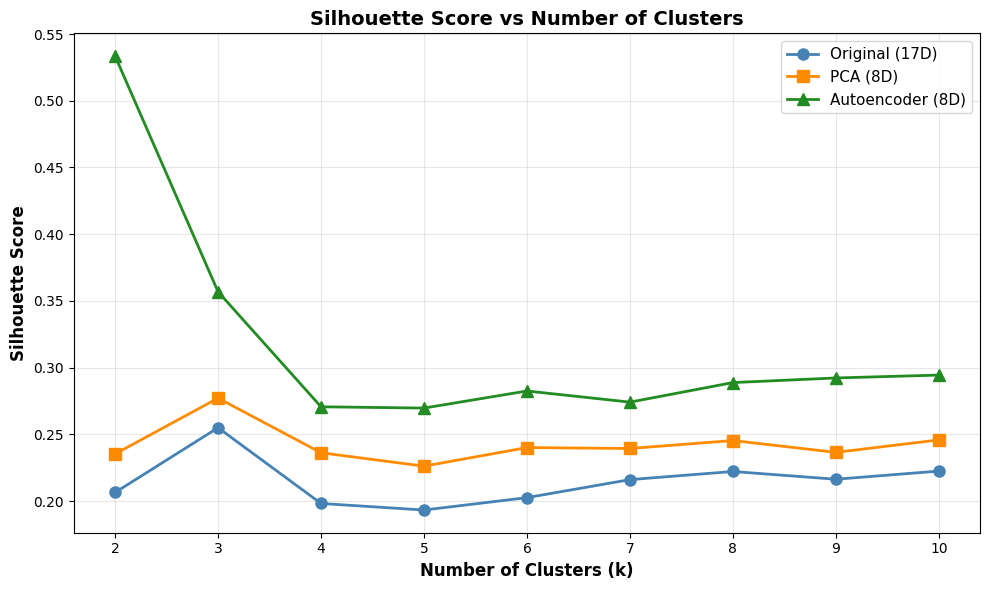


Optimal k (based on Silhouette Score):
  Original: k=3 (score=0.2550)
  PCA: k=3 (score=0.2771)
  Autoencoder: k=2 (score=0.5335)


In [35]:
# ==== Silhouette scores for different k ====
silhouette_original = []
silhouette_pca = []
silhouette_ae = []

print("\n" + "="*80)
print("SILHOUETTE ANALYSIS")
print("="*80)

for k in k_range:
    # Original
    kmeans_orig = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_orig = kmeans_orig.fit_predict(X_train)
    sil_orig = silhouette_score(X_train, labels_orig)
    silhouette_original.append(sil_orig)

    # PCA
    kmeans_pca_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_pca = kmeans_pca_temp.fit_predict(X_train_credit_pca)
    sil_pca = silhouette_score(X_train_credit_pca, labels_pca)
    silhouette_pca.append(sil_pca)

    # Autoencoder
    kmeans_ae_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_ae = kmeans_ae_temp.fit_predict(X_train_ae_credit)
    sil_ae = silhouette_score(X_train_ae_credit, labels_ae)
    silhouette_ae.append(sil_ae)

    print(f"k={k}: Silhouette Original={sil_orig:.4f}, PCA={sil_pca:.4f}, AE={sil_ae:.4f}")

# ==== Plot Silhouette Scores ====
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_range, silhouette_original, marker='o', linewidth=2, markersize=8, label='Original (17D)', color='steelblue')
ax.plot(k_range, silhouette_pca, marker='s', linewidth=2, markersize=8, label='PCA (8D)', color='darkorange')
ax.plot(k_range, silhouette_ae, marker='^', linewidth=2, markersize=8, label='Autoencoder (8D)', color='forestgreen')

ax.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_range)

plt.tight_layout()
plt.savefig('kmeans_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal k (highest silhouette)
optimal_k_orig = k_range[np.argmax(silhouette_original)]
optimal_k_pca = k_range[np.argmax(silhouette_pca)]
optimal_k_ae = k_range[np.argmax(silhouette_ae)]

print(f"\nOptimal k (based on Silhouette Score):")
print(f"  Original: k={optimal_k_orig} (score={max(silhouette_original):.4f})")
print(f"  PCA: k={optimal_k_pca} (score={max(silhouette_pca):.4f})")
print(f"  Autoencoder: k={optimal_k_ae} (score={max(silhouette_ae):.4f})")

In [36]:
# ==== Choose k (based on elbow + silhouette) ====
CHOSEN_K = 3  # Adjust based on elbow/silhouette analysis above

print("\n" + "="*80)
print(f"TRAINING FINAL K-MEANS MODELS WITH k={CHOSEN_K}")
print("="*80)

# ==== Model 1: K-Means on Original Data ====
start_time = time.time()
kmeans_original = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10, max_iter=300)
labels_train_original = kmeans_original.fit_predict(X_train)
labels_test_original = kmeans_original.predict(X_test)
time_original = time.time() - start_time

# Metrics
inertia_original = kmeans_original.inertia_
silhouette_original_final = silhouette_score(X_train, labels_train_original)
davies_bouldin_original = davies_bouldin_score(X_train, labels_train_original)
calinski_harabasz_original = calinski_harabasz_score(X_train, labels_train_original)

print(f"\nMODEL 1: K-Means on Original Data (17D)")
print(f"  Inertia: {inertia_original:.4f}")
print(f"  Silhouette Score: {silhouette_original_final:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_original:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_original:.4f}")
print(f"  Training Time: {time_original:.4f} seconds")
print(f"  Iterations: {kmeans_original.n_iter_}")

# ==== Model 2: K-Means on PCA Data ====
start_time = time.time()
kmeans_pca_final = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10, max_iter=300)
labels_train_pca = kmeans_pca_final.fit_predict(X_train_credit_pca)
labels_test_pca = kmeans_pca_final.predict(X_test_credit_pca)
time_pca = time.time() - start_time

inertia_pca_final = kmeans_pca_final.inertia_
silhouette_pca_final = silhouette_score(X_train_credit_pca, labels_train_pca)
davies_bouldin_pca = davies_bouldin_score(X_train_credit_pca, labels_train_pca)
calinski_harabasz_pca = calinski_harabasz_score(X_train_credit_pca, labels_train_pca)

print(f"\nMODEL 2: K-Means on PCA Data (8D)")
print(f"  Inertia: {inertia_pca_final:.4f}")
print(f"  Silhouette Score: {silhouette_pca_final:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_pca:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_pca:.4f}")
print(f"  Training Time: {time_pca:.4f} seconds")
print(f"  Iterations: {kmeans_pca_final.n_iter_}")

# ==== Model 3: K-Means on Autoencoder Data ====
start_time = time.time()
kmeans_ae_final = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10, max_iter=300)
labels_train_ae = kmeans_ae_final.fit_predict(X_train_ae_credit)
labels_test_ae = kmeans_ae_final.predict(X_test_ae_credit)
time_ae = time.time() - start_time

inertia_ae_final = kmeans_ae_final.inertia_
silhouette_ae_final = silhouette_score(X_train_ae_credit, labels_train_ae)
davies_bouldin_ae = davies_bouldin_score(X_train_ae_credit, labels_train_ae)
calinski_harabasz_ae = calinski_harabasz_score(X_train_ae_credit, labels_train_ae)

print(f"\nMODEL 3: K-Means on Autoencoder Data (8D)")
print(f"  Inertia: {inertia_ae_final:.4f}")
print(f"  Silhouette Score: {silhouette_ae_final:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_ae:.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_ae:.4f}")
print(f"  Training Time: {time_ae:.4f} seconds")
print(f"  Iterations: {kmeans_ae_final.n_iter_}")


TRAINING FINAL K-MEANS MODELS WITH k=3

MODEL 1: K-Means on Original Data (17D)
  Inertia: 89519.8110
  Silhouette Score: 0.2550
  Davies-Bouldin Index: 1.5855
  Calinski-Harabasz Score: 1295.4988
  Training Time: 0.1692 seconds
  Iterations: 22

MODEL 2: K-Means on PCA Data (8D)
  Inertia: 71879.6852
  Silhouette Score: 0.2771
  Davies-Bouldin Index: 1.3978
  Calinski-Harabasz Score: 1601.9866
  Training Time: 0.1370 seconds
  Iterations: 25

MODEL 3: K-Means on Autoencoder Data (8D)
  Inertia: 107330.8984
  Silhouette Score: 0.3569
  Davies-Bouldin Index: 1.1079
  Calinski-Harabasz Score: 5233.1343
  Training Time: 0.1271 seconds
  Iterations: 9


In [37]:
# ==== Summary Table ====
results_kmeans_df = pd.DataFrame({
    'Model': ['K-Means Original (17D)', 'K-Means PCA (8D)', 'K-Means Autoencoder (8D)'],
    'k': [CHOSEN_K, CHOSEN_K, CHOSEN_K],
    'Silhouette Score': [silhouette_original_final, silhouette_pca_final, silhouette_ae_final],
    'Inertia': [inertia_original, inertia_pca_final, inertia_ae_final],
    'Davies-Bouldin': [davies_bouldin_original, davies_bouldin_pca, davies_bouldin_ae],
    'Calinski-Harabasz': [calinski_harabasz_original, calinski_harabasz_pca, calinski_harabasz_ae],
    'Training Time (s)': [time_original, time_pca, time_ae],
    'Iterations': [kmeans_original.n_iter_, kmeans_pca_final.n_iter_, kmeans_ae_final.n_iter_]
})

print("\n" + "="*80)
print("COMPARATIVE RESULTS: CREDIT CARD CLUSTERING")
print("="*80)
print(results_kmeans_df.to_string(index=False))
print("\n" + "="*80)


COMPARATIVE RESULTS: CREDIT CARD CLUSTERING
                   Model  k  Silhouette Score       Inertia  Davies-Bouldin  Calinski-Harabasz  Training Time (s)  Iterations
  K-Means Original (17D)  3          0.254962  89519.810992        1.585531        1295.498844           0.169210          22
        K-Means PCA (8D)  3          0.277141  71879.685229        1.397804        1601.986557           0.136960          25
K-Means Autoencoder (8D)  3          0.356861 107330.898438        1.107872        5233.134277           0.127116           9



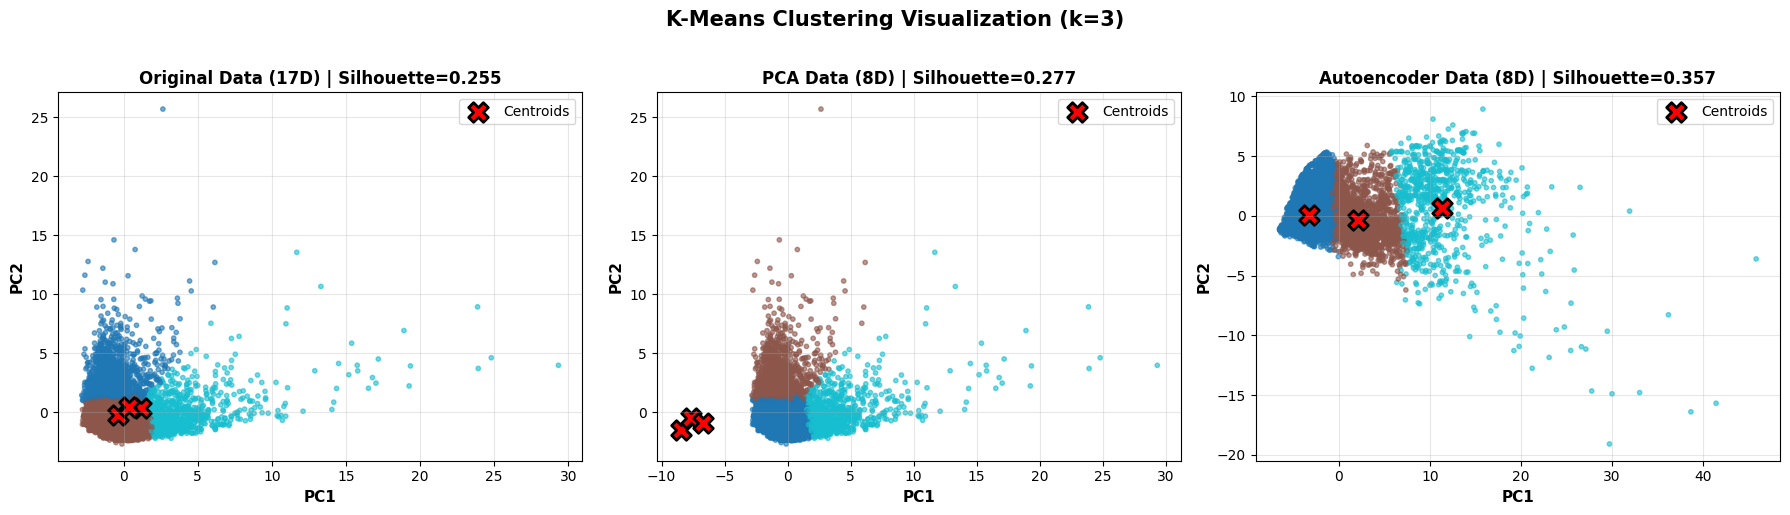

In [38]:
# ==== 2D Visualization using PCA ====
pca_2d = PCA_viz(n_components=2, random_state=42)

# Original data
X_train_2d_orig = pca_2d.fit_transform(X_train)

# PCA data (already 8D, project to 2D)
X_train_2d_pca = pca_2d.fit_transform(X_train_credit_pca)

# Autoencoder data
X_train_2d_ae = pca_2d.fit_transform(X_train_ae_credit)

# ==== Plot clusters ====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(X_train_2d_orig[:, 0], X_train_2d_orig[:, 1],
                          c=labels_train_original, cmap='tab10', s=10, alpha=0.6)
axes[0].scatter(kmeans_original.cluster_centers_[:, 0], kmeans_original.cluster_centers_[:, 1],
               c='red', marker='X', s=200, edgecolor='black', linewidth=2, label='Centroids')
axes[0].set_xlabel('PC1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('PC2', fontsize=11, fontweight='bold')
axes[0].set_title(f'Original Data (17D) | Silhouette={silhouette_original_final:.3f}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

scatter2 = axes[1].scatter(X_train_2d_pca[:, 0], X_train_2d_pca[:, 1],
                          c=labels_train_pca, cmap='tab10', s=10, alpha=0.6)
pca_centers_2d = pca_2d.transform(kmeans_pca_final.cluster_centers_)
axes[1].scatter(pca_centers_2d[:, 0], pca_centers_2d[:, 1],
               c='red', marker='X', s=200, edgecolor='black', linewidth=2, label='Centroids')
axes[1].set_xlabel('PC1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('PC2', fontsize=11, fontweight='bold')
axes[1].set_title(f'PCA Data (8D) | Silhouette={silhouette_pca_final:.3f}', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

scatter3 = axes[2].scatter(X_train_2d_ae[:, 0], X_train_2d_ae[:, 1],
                          c=labels_train_ae, cmap='tab10', s=10, alpha=0.6)
ae_centers_2d = pca_2d.transform(kmeans_ae_final.cluster_centers_)
axes[2].scatter(ae_centers_2d[:, 0], ae_centers_2d[:, 1],
               c='red', marker='X', s=200, edgecolor='black', linewidth=2, label='Centroids')
axes[2].set_xlabel('PC1', fontsize=11, fontweight='bold')
axes[2].set_ylabel('PC2', fontsize=11, fontweight='bold')
axes[2].set_title(f'Autoencoder Data (8D) | Silhouette={silhouette_ae_final:.3f}', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'K-Means Clustering Visualization (k={CHOSEN_K})', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('kmeans_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


COMPUTATIONAL COST ANALYSIS: CREDIT CARD CLUSTERING

Inference Time (per sample):
  K-Means Original: 0.0010 ms
  K-Means PCA: 0.0007 ms
  K-Means Autoencoder: 0.0006 ms
  Speedup: PCA=1.56x, AE=1.66x

Memory Footprint (cluster centers):
  K-Means Original: 0.40 KB
  K-Means PCA: 0.19 KB
  K-Means Autoencoder: 0.19 KB
  Reduction: PCA=52.9%, AE=52.9%

CREDIT CARD K-MEANS: COMPUTATIONAL COST SUMMARY
                   Model  Dimensionality  k (clusters)  Training Time (s)  Iterations  Inference Time (ms)  Memory (KB)  Silhouette Score
  K-Means Original (17D)              17             3           0.169210          22             0.001049     0.398438          0.254962
        K-Means PCA (8D)               8             3           0.136960          25             0.000672     0.187500          0.277141
K-Means Autoencoder (8D)               8             3           0.127116           9             0.000631     0.187500          0.356861


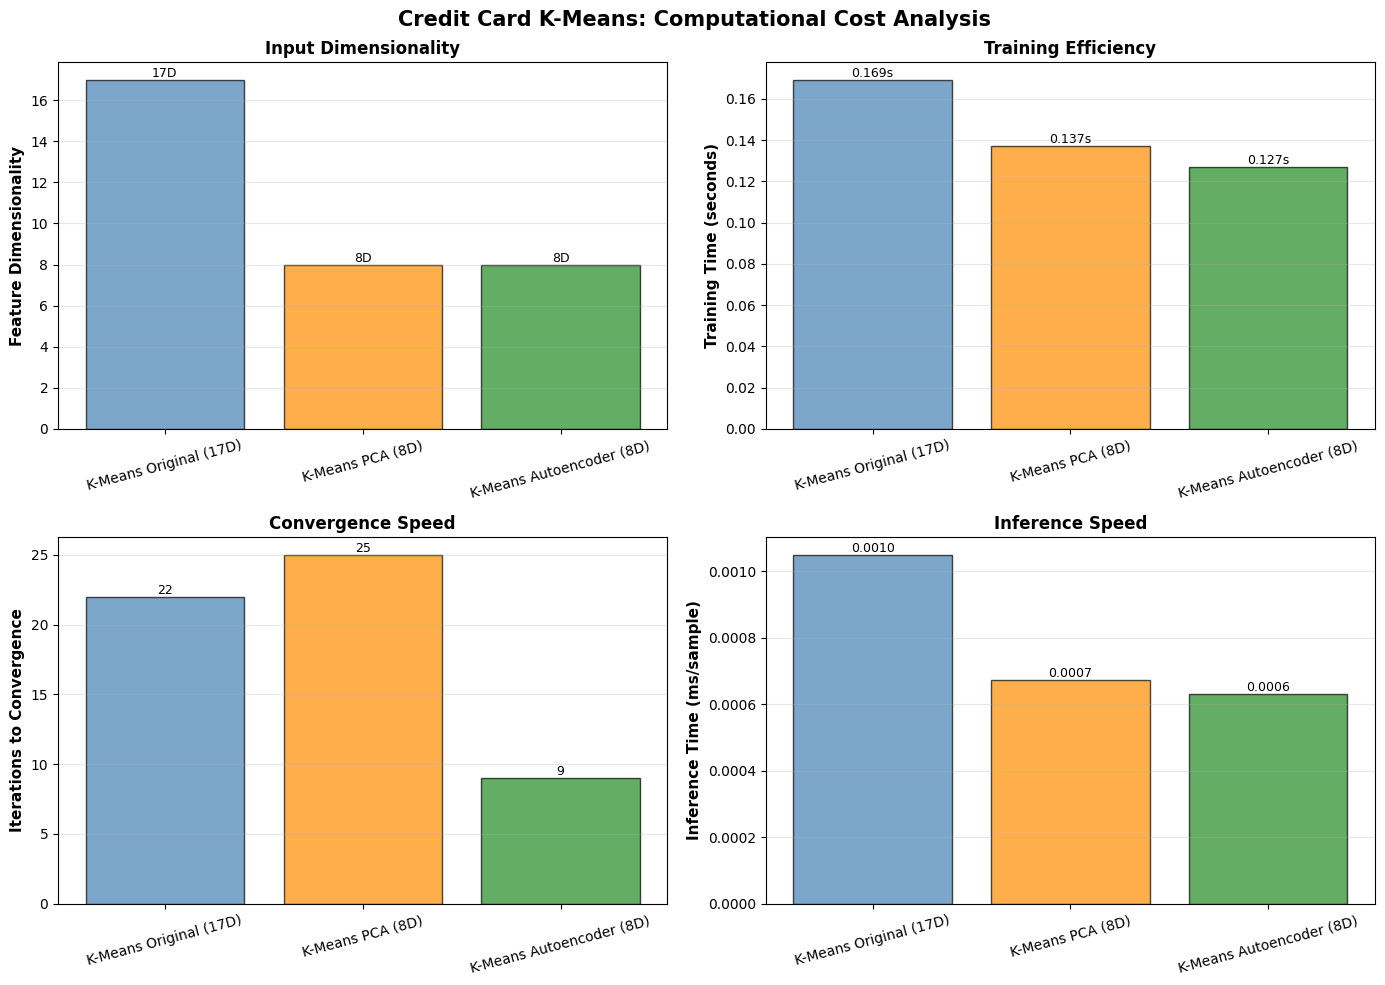

In [39]:
# ==============================================================================
# CREDIT CARD K-MEANS: COMPUTATIONAL COST ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("COMPUTATIONAL COST ANALYSIS: CREDIT CARD CLUSTERING")
print("="*80)

# ==== K-Means has no "parameters" in the neural network sense ====
# Instead, we focus on: training time, inference time, iterations, cluster centers

# Training times already recorded: time_original, time_pca, time_ae

# ==== Inference Time (cluster assignment) ====
n_inference_samples = 1000
inference_data_kmeans_original = X_test[:n_inference_samples]
inference_data_kmeans_pca = X_test_credit_pca[:n_inference_samples]
inference_data_kmeans_ae = X_test_ae_credit[:n_inference_samples]

# Original
start = time.time()
_ = kmeans_original.predict(inference_data_kmeans_original)
inference_time_kmeans_original = (time.time() - start) / n_inference_samples * 1000

# PCA
start = time.time()
_ = kmeans_pca_final.predict(inference_data_kmeans_pca)
inference_time_kmeans_pca = (time.time() - start) / n_inference_samples * 1000

# Autoencoder
start = time.time()
_ = kmeans_ae_final.predict(inference_data_kmeans_ae)
inference_time_kmeans_ae = (time.time() - start) / n_inference_samples * 1000

print(f"\nInference Time (per sample):")
print(f"  K-Means Original: {inference_time_kmeans_original:.4f} ms")
print(f"  K-Means PCA: {inference_time_kmeans_pca:.4f} ms")
print(f"  K-Means Autoencoder: {inference_time_kmeans_ae:.4f} ms")
print(f"  Speedup: PCA={inference_time_kmeans_original/inference_time_kmeans_pca:.2f}x, AE={inference_time_kmeans_original/inference_time_kmeans_ae:.2f}x")

# ==== Memory footprint (cluster centers only) ====
# K-Means stores k centroids of dimensionality d
memory_original = CHOSEN_K * 17 * 8 / 1024  # 8 bytes per float64, in KB
memory_pca = CHOSEN_K * 8 * 8 / 1024
memory_ae = CHOSEN_K * 8 * 8 / 1024

print(f"\nMemory Footprint (cluster centers):")
print(f"  K-Means Original: {memory_original:.2f} KB")
print(f"  K-Means PCA: {memory_pca:.2f} KB")
print(f"  K-Means Autoencoder: {memory_ae:.2f} KB")
print(f"  Reduction: PCA={100*(1-memory_pca/memory_original):.1f}%, AE={100*(1-memory_ae/memory_original):.1f}%")

# ==== Summary Table ====
kmeans_cost_df = pd.DataFrame({
    'Model': ['K-Means Original (17D)', 'K-Means PCA (8D)', 'K-Means Autoencoder (8D)'],
    'Dimensionality': [17, 8, 8],
    'k (clusters)': [CHOSEN_K, CHOSEN_K, CHOSEN_K],
    'Training Time (s)': [time_original, time_pca, time_ae],
    'Iterations': [kmeans_original.n_iter_, kmeans_pca_final.n_iter_, kmeans_ae_final.n_iter_],
    'Inference Time (ms)': [inference_time_kmeans_original, inference_time_kmeans_pca, inference_time_kmeans_ae],
    'Memory (KB)': [memory_original, memory_pca, memory_ae],
    'Silhouette Score': [silhouette_original_final, silhouette_pca_final, silhouette_ae_final]
})

print("\n" + "="*80)
print("CREDIT CARD K-MEANS: COMPUTATIONAL COST SUMMARY")
print("="*80)
print(kmeans_cost_df.to_string(index=False))
print("="*80)

# ==== Visualization ====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Dimensionality
axes[0, 0].bar(kmeans_cost_df['Model'], kmeans_cost_df['Dimensionality'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 0].set_ylabel('Feature Dimensionality', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Input Dimensionality', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(kmeans_cost_df['Dimensionality']):
    axes[0, 0].text(i, v, f'{v}D', ha='center', va='bottom', fontsize=9)

# Plot 2: Training Time
axes[0, 1].bar(kmeans_cost_df['Model'], kmeans_cost_df['Training Time (s)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[0, 1].set_ylabel('Training Time (seconds)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Training Efficiency', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(kmeans_cost_df['Training Time (s)']):
    axes[0, 1].text(i, v, f'{v:.3f}s', ha='center', va='bottom', fontsize=9)

# Plot 3: Iterations
axes[1, 0].bar(kmeans_cost_df['Model'], kmeans_cost_df['Iterations'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 0].set_ylabel('Iterations to Convergence', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Convergence Speed', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(kmeans_cost_df['Iterations']):
    axes[1, 0].text(i, v, f'{v}', ha='center', va='bottom', fontsize=9)

# Plot 4: Inference Time
axes[1, 1].bar(kmeans_cost_df['Model'], kmeans_cost_df['Inference Time (ms)'],
               color=['steelblue', 'darkorange', 'forestgreen'], edgecolor='black', alpha=0.7)
axes[1, 1].set_ylabel('Inference Time (ms/sample)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Inference Speed', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(kmeans_cost_df['Inference Time (ms)']):
    axes[1, 1].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Credit Card K-Means: Computational Cost Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('kmeans_computational_cost.png', dpi=300, bbox_inches='tight')
plt.show()